## Library

In [1]:
import dill
import math
import random

import numpy as np
import matplotlib.pyplot as plt

import squigglepy as sq
from squigglepy import bayes
from squigglepy.numbers import K, M, B, T

from copy import copy, deepcopy
from scipy import stats
from pprint import pprint
print('Loaded 1')

exec(open('utils.py').read())
print('Loaded 2')

exec(open('modules/tai_timelines.py').read())
print('Loaded TAI timelines module')


Loaded 1
Loaded 2
Loaded TAI timelines module


## Variables

In [2]:
# Global variables - probably don't want to change these but you could.
RUNS = 10000                                      # Number of runs to do (default 10000)
CURRENT_YEAR = 2023                               # What year to start the run on? (default: 2023)
MAX_YEAR = 2123                                   # What year to end the run on? (default: 2123)
years = list(range(CURRENT_YEAR, MAX_YEAR))

In [3]:
tai_flop_size = sq.sample(load_cache_file='caches/meta_anchor')  # Cache generated in "Anchors" notebook
# tai_flop_size = sq.sample(load_cache_file='caches/meta_anchor_metaculus_agi')
# tai_flop_size = sq.sample(load_cache_file='caches/meta_anchor_metaculus_turing')
# tai_flop_size = sq.sample(load_cache_file='caches/meta_anchor_metaculus_parity')
tai_flop_size = [round(t, 1) for t in tai_flop_size]
sq.get_percentiles(tai_flop_size)

{1: 24.5,
 5: 25.9,
 10: 26.6,
 20: 27.7,
 30: 28.6,
 40: 29.7,
 50: 31.2,
 60: 33.1,
 70: 35.1,
 80: 37.6,
 90: 41.3,
 95: 44.3,
 99: 50.5}

In [4]:
initial_pay = sq.sample(load_cache_file='caches/initial_pay')  # Cache generated in "Initial pay" notebook
initial_pay = [round(p, 1) for p in initial_pay]
# TODO: Suspicious this is not working in the model correctly
sq.get_percentiles(initial_pay)

{1: 7.4,
 5: 7.6,
 10: 7.7,
 20: 7.9,
 30: 8.0,
 40: 8.1,
 50: 8.2,
 60: 8.3,
 70: 8.5,
 80: 8.7,
 90: 9.0,
 95: 9.3,
 99: 9.8}

In [5]:
# PROBABILITY OF A NONSCALING DELAY

# set to None to have no delay
# Otherwise specified in a dictionary
# {'delay': {'prob': <array of probabilities by year>, 'length': <distribution to sample from to get length of delay>}}

# Cache defined in "(3B) Nonscaling Delay Curve"

with open('caches/nonscaling_delays.dill', 'rb') as f:
    delay = dill.load(f)

# del delay['real_world_feedback']
# del delay['robotics']
delay

{'algorithms': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> mixture
   - <Distribution> lognorm(mean=1.7, sd=0.37)
   - <Distribution> lognorm(mean=2.25, sd=0.7)},
 'data': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> lognorm(mean=1.15, sd=0.7)},
 'robotics': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> mixture
   - <Distribution> lognorm(mean=0.8, sd=0.49)
   - <Distribution> lognorm(mean=1.96, sd=0.21)},
 'real_world_feedback': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> mixture
   - <Distribution> lognorm(mean=0.8, sd=0.49)
   - <Distribution> lognorm(mean=1.96, sd=0.21)
   - <Distribution> lognorm(mean=2.85, sd=0.33)},
 'policy_pause': {'prob': <function __main__.derive_nonscaling_d

In [6]:
def wildeford_max_gdp_frac():
    small_project = sq.lognorm(1 / (250*K), 1 / (3*K))
    modern_megaproject = sq.lognorm(1/K, 1/600)
    old_form_megaproject = sq.lognorm(1/K, 1/150)
    gigaproject = sq.lognorm(1/150, 1/50)
    
    r_ = random.random()
    if r_ < 0.1:
        gdp_frac = small_project
        percent_spent_on_compute = sq.lognorm(0.5, 0.95, lclip=0.1, rclip=0.999)
    elif r_ < 0.7:
        gdp_frac = modern_megaproject
        percent_spent_on_compute = sq.lognorm(0.7, 0.95, lclip=0.1, rclip=0.999)
    elif r_ < 0.9:
        gdp_frac = old_form_megaproject
        percent_spent_on_compute = sq.lognorm(0.85, 0.95, lclip=0.1, rclip=0.999)
    else:
        gdp_frac = gigaproject
        percent_spent_on_compute = sq.lognorm(0.85, 0.99, lclip=0.1, rclip=0.999)
        
    models_trained_per_year_for_budget = sq.lognorm(1, 10)

    return ~gdp_frac * ~percent_spent_on_compute / ~models_trained_per_year_for_budget


variables = {'initial_gdp': 23*T,
             'tai_flop_size': tai_flop_size,
             'algo_doubling_rate_max': 3,
             'algo_doubling_rate_min': 1,
             'min_reduction': 2,
             'max_reduction': 5,
             'initial_flop_per_dollar': 18.3,
             'flop_halving_rate': sq.norm(2, 3),         # https://epochai.org/blog/predicting-gpu-performance
             'max_flop_per_dollar': sq.lognorm(21, 24),  # https://epochai.org/blog/predicting-gpu-performance
             'initial_pay': initial_pay,
             'gdp_growth': sq.lognorm(1.01, 1.035, lclip=1.005),
             'max_gdp_frac': wildeford_max_gdp_frac, # TODO: Willingness to spend connected to commercialization
             'spend_doubling_time': sq.norm(1.5, 4.5, lclip=1),
             '2025_spend_doubling_time': sq.norm(0.93, 1.05, lclip=0.9),
             'nonscaling_delay': delay}

print('Loaded')


Loaded


## Run Wildeford timelines model

-
-
## SAMPLE RUN 1 ##
It takes 28.0 log FLOP (~10 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.3 years they get 2x cheaper, to a maximum of 23.4 log FLOP (~247 sextillion) per 2022$USD.
We are initially willing to pay 8.0 log 2022$USD (~100 million). This doubles every 1.0 years until 2025, and then doubles every 2.7 years to a max of 0.000977% of GDP. GDP grows at a rate of 1.021x per year.
---
Year: 2023 - 26.3 max log FLOP (199 septillion) available - TAI takes 28.0 log FLOP (10 octillion) - log $ 9.7 to buy TAI (5 billion) vs. willingness to pay log $ 8.0 (100 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.7 max log FLOP (543 septillion) available - TAI takes 27.9 log FLOP (8 octillion) - log $ 9.5 to buy TAI (3 billion) vs. willingness to pay log $ 8.3 (201 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 

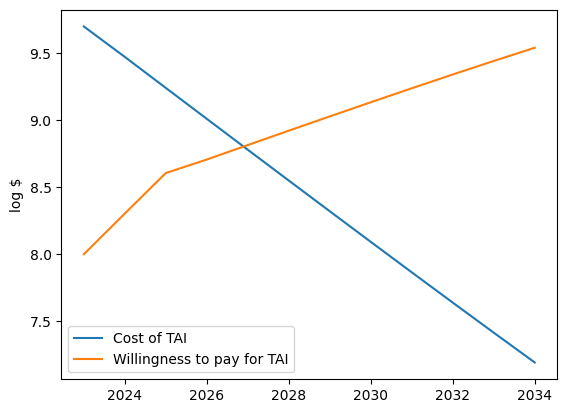

-
-
## SAMPLE RUN 2 ##
It takes 32.1 log FLOP (~126 nonillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.0 years they get 2x cheaper, to a maximum of 21.7 log FLOP (~5 sextillion) per 2022$USD.
We are initially willing to pay 8.5 log 2022$USD (~316 million). This doubles every 1.1 years until 2025, and then doubles every 3.7 years to a max of 0.000376% of GDP. GDP grows at a rate of 1.016x per year.
---
Year: 2023 - 26.8 max log FLOP (608 septillion) available - TAI takes 32.1 log FLOP (126 nonillion) - log $ 13.8 to buy TAI (63 trillion) vs. willingness to pay log $ 8.5 (305 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 27.2 max log FLOP (2 octillion) available - TAI takes 32.0 log FLOP (90 nonillion) - log $ 13.5 to buy TAI (32 trillion) vs. willingness to pay log $ 8.8 (571 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 202

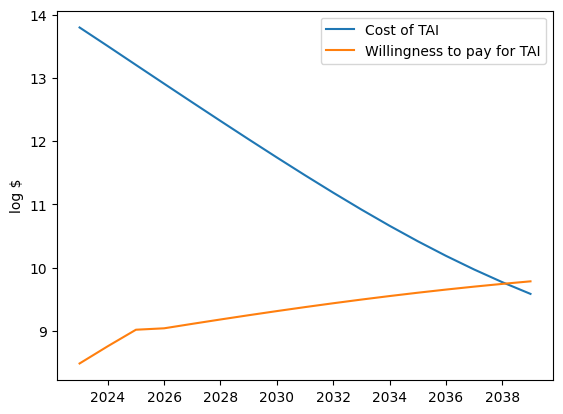

-
-
## SAMPLE RUN 3 ##
It takes 38.4 log FLOP (~251 thousand decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 4 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.5 years they get 2x cheaper, to a maximum of 23.1 log FLOP (~140 sextillion) per 2022$USD.
We are initially willing to pay 8.1 log 2022$USD (~126 million). This doubles every 1.0 years until 2025, and then doubles every 3.3 years to a max of 0.000267% of GDP. GDP grows at a rate of 1.039x per year.
---
Year: 2023 - 26.4 max log FLOP (246 septillion) available - TAI takes 38.4 log FLOP (251 thousand decillion) - log $ 20.1 to buy TAI (126 quintillion) vs. willingness to pay log $ 8.1 (123 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.8 max log FLOP (627 septillion) available - TAI takes 38.1 log FLOP (126 thousand decillion) - log $ 19.7 to buy TAI (48 quintillion) vs. willingness to pay log $ 8.4 (239 million) - 18.4 lo

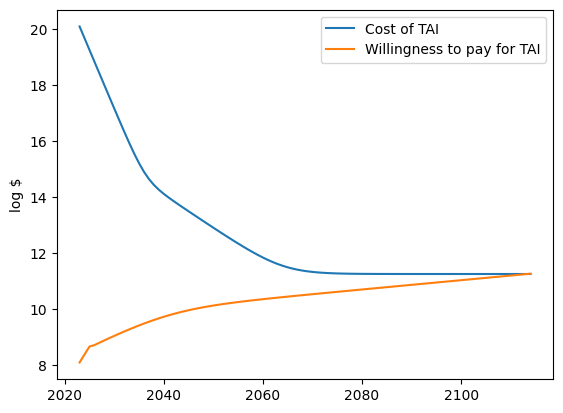

-
-
## RUN TIMELINES MODEL ##
Generating Bayes net...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [03:34<00:00, 46.59it/s]


Caching in-memory...
...Cached!
Writing cache to file `caches/tai_years.sqcache`...
...Cached!
...Reducing
...Reduced!
...All done!
-
## DISTRIBUTION OF TAI ARRIVAL DATE ##
['5%: 2030',
 '10%: 2031',
 '15%: 2033',
 '20%: 2034',
 '25%: 2035',
 '35%: 2037',
 '50%: 2043',
 '60%: 2050',
 '75%: >2123',
 '80%: >2123',
 '90%: >2123',
 '95%: >2123']
-
-
## DISTRIBUTION OF RELATIVE TAI ARRIVAL DATE ##
['5%: 7 years from now',
 '10%: 8 years from now',
 '15%: 10 years from now',
 '20%: 11 years from now',
 '25%: 12 years from now',
 '35%: 14 years from now',
 '50%: 20 years from now',
 '60%: 27 years from now',
 '75%: >100 years from now',
 '80%: >100 years from now',
 '90%: >100 years from now',
 '95%: >100 years from now']
-
-
## TAI ARRIVAL DATE BY BIN ##
This year: 0.0%
2024-2027: 0.5%
2028-2029: 3.6%
2030-2034: 19.2%
2035-2039: 18.6%
2040-2049: 17.3%
2050-2059: 8.3%
2060-2069: 3.0%
2070-2079: 1.4%
2080-2089: 0.7%
2090-2099: 0.6%
2100-2109: 0.5%
2110-2119: 0.5%
>2120: 25.8%
-
-
## TAI ARRIVA

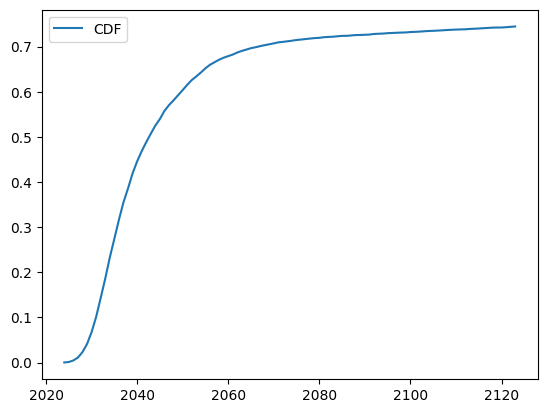

<string>:173: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<string>:174: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#d

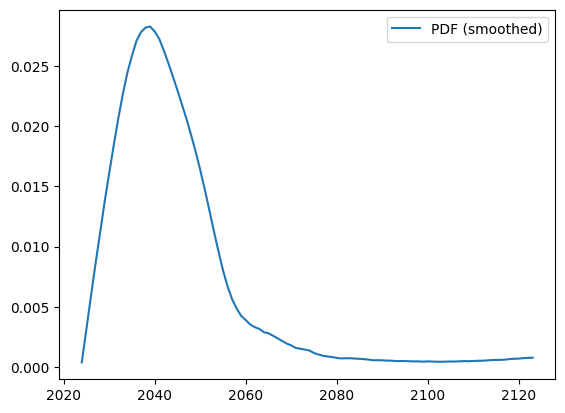

-
-
## TAI FLOP SIZE ##
{1: 24.4,
 5: 25.8,
 10: 26.5,
 20: 27.4,
 30: 28.3,
 40: 29.3,
 50: 31.0,
 60: 32.8,
 70: 34.9,
 80: 37.3,
 90: 41.1,
 95: 44.8,
 99: 51.5}


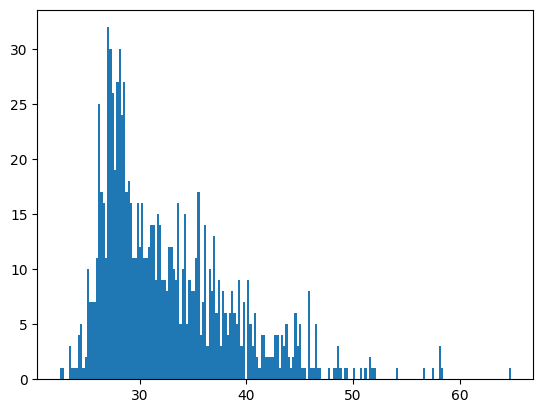

-
-
## MIN REDUCTION: 2 ##
-
## MAX REDUCTION: 5 ##
-
## MIN ALGO DOUBLING RATE: 1 ##
-
## MAX ALGO DOUBLING RATE: 3 ##
-
## INITIAL FLOP PER DOLLAR: 18.3 ##
-
## FLOP HALVING RATE ##
{1: 3.2,
 5: 3.0,
 10: 2.9,
 20: 2.8,
 30: 2.7,
 40: 2.6,
 50: 2.5,
 60: 2.4,
 70: 2.4,
 80: 2.3,
 90: 2.1,
 95: 2.0,
 99: 1.8}


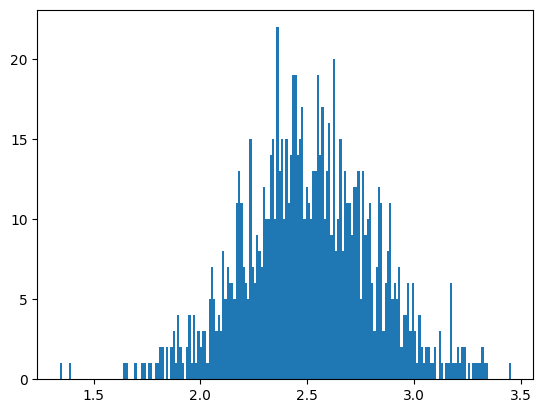

-
-
## MAX FLOP PER DOLLAR ##
{1: 20.4,
 5: 21.0,
 10: 21.2,
 20: 21.6,
 30: 21.9,
 40: 22.2,
 50: 22.4,
 60: 22.6,
 70: 22.9,
 80: 23.2,
 90: 23.6,
 95: 24.0,
 99: 24.6}


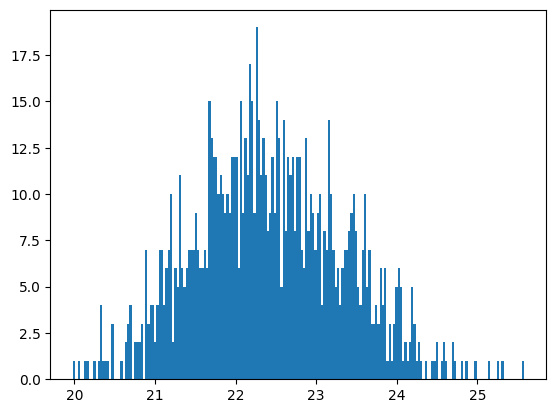

-
-
## INITIAL PAY ##
{1: 7.4,
 5: 7.6,
 10: 7.7,
 20: 7.8,
 30: 8.0,
 40: 8.1,
 50: 8.2,
 60: 8.3,
 70: 8.4,
 80: 8.6,
 90: 8.9,
 95: 9.2,
 99: 9.7}


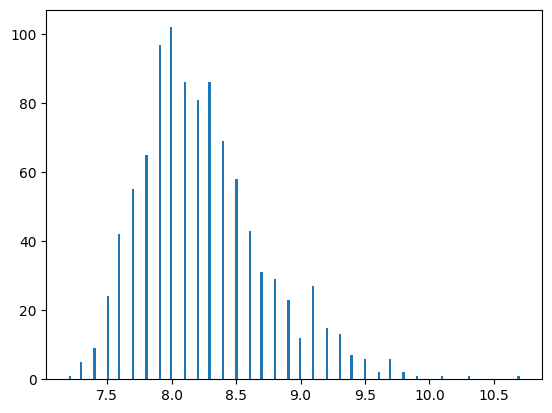

-
-
## GDP GROWTH ##
{1: 1.0,
 5: 1.01,
 10: 1.01,
 20: 1.02,
 30: 1.02,
 40: 1.02,
 50: 1.02,
 60: 1.02,
 70: 1.03,
 80: 1.03,
 90: 1.03,
 95: 1.04,
 99: 1.04}


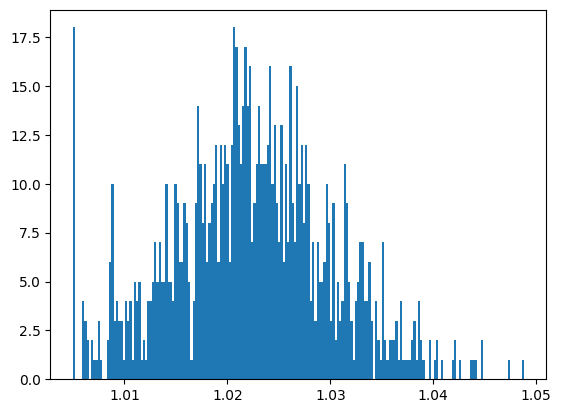

-
-
## MAX GDP FRAC ##
{1: 0.0,
 5: 1e-05,
 10: 8e-05,
 20: 0.00017,
 30: 0.00024,
 40: 0.0003,
 50: 0.00038,
 60: 0.0005,
 70: 0.00069,
 80: 0.00106,
 90: 0.00239,
 95: 0.00375,
 99: 0.00868}


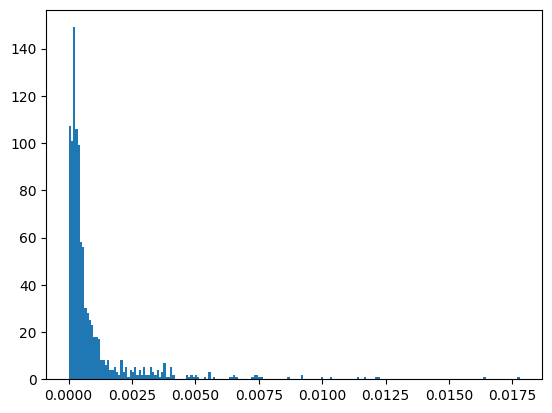

-
-
## SPEND DOUBLING TIME ##
{1: 5.0,
 5: 4.4,
 10: 4.1,
 20: 3.7,
 30: 3.4,
 40: 3.2,
 50: 3.0,
 60: 2.8,
 70: 2.6,
 80: 2.3,
 90: 1.9,
 95: 1.5,
 99: 1.0}


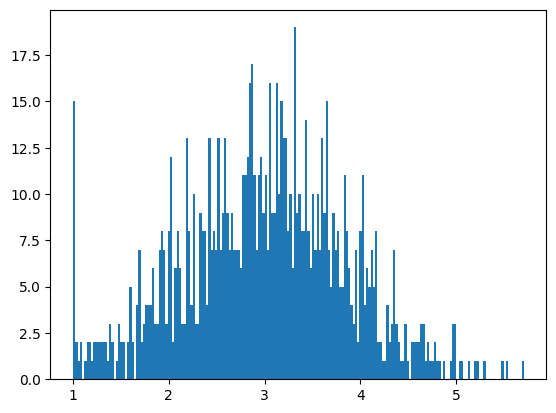

-
-
-
-
## GDP Over Time ##


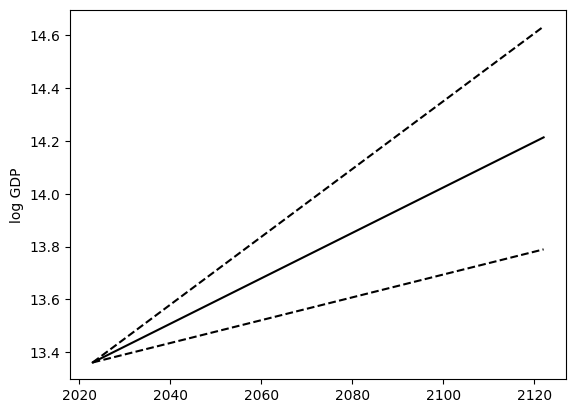

Year: 2023 - GDP log 2022$USD 13.4 (~23 trillion) 90% CI 13.4 (~23 trillion) - 13.4 (~23 trillion)
Year: 2024 - GDP log 2022$USD 13.4 (~23 trillion) 90% CI 13.4 (~23 trillion) - 13.4 (~24 trillion)
Year: 2025 - GDP log 2022$USD 13.4 (~24 trillion) 90% CI 13.4 (~23 trillion) - 13.4 (~24 trillion)
Year: 2026 - GDP log 2022$USD 13.4 (~24 trillion) 90% CI 13.4 (~24 trillion) - 13.4 (~25 trillion)
Year: 2027 - GDP log 2022$USD 13.4 (~25 trillion) 90% CI 13.4 (~24 trillion) - 13.4 (~26 trillion)
Year: 2028 - GDP log 2022$USD 13.4 (~25 trillion) 90% CI 13.4 (~24 trillion) - 13.4 (~27 trillion)
Year: 2029 - GDP log 2022$USD 13.4 (~26 trillion) 90% CI 13.4 (~24 trillion) - 13.4 (~27 trillion)
Year: 2030 - GDP log 2022$USD 13.4 (~26 trillion) 90% CI 13.4 (~25 trillion) - 13.5 (~28 trillion)
Year: 2031 - GDP log 2022$USD 13.4 (~27 trillion) 90% CI 13.4 (~25 trillion) - 13.5 (~29 trillion)
Year: 2032 - GDP log 2022$USD 13.4 (~27 trillion) 90% CI 13.4 (~25 trillion) - 13.5 (~30 trillion)
Year: 2033

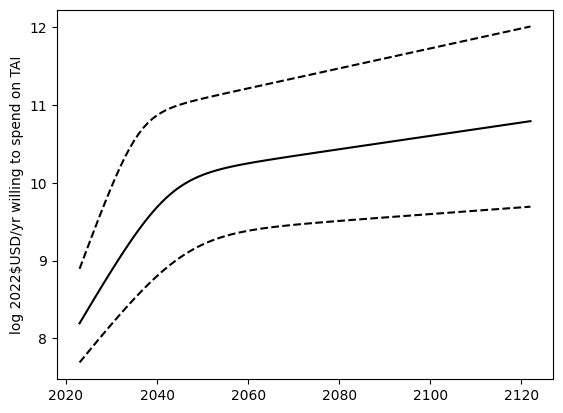

Year: 2023 - willingness log 2022$USD per year 8.2 (~156 million) 90% CI 7.7 (~49 million) - 8.9 (~783 million)
Year: 2024 - willingness log 2022$USD per year 8.3 (~195 million) 90% CI 7.8 (~58 million) - 9.0 (~1 billion)
Year: 2025 - willingness log 2022$USD per year 8.4 (~245 million) 90% CI 7.8 (~68 million) - 9.2 (~2 billion)
Year: 2026 - willingness log 2022$USD per year 8.5 (~307 million) 90% CI 7.9 (~80 million) - 9.4 (~2 billion)
Year: 2027 - willingness log 2022$USD per year 8.6 (~383 million) 90% CI 8.0 (~94 million) - 9.5 (~3 billion)
Year: 2028 - willingness log 2022$USD per year 8.7 (~478 million) 90% CI 8.0 (~110 million) - 9.7 (~5 billion)
Year: 2029 - willingness log 2022$USD per year 8.8 (~596 million) 90% CI 8.1 (~129 million) - 9.8 (~6 billion)
Year: 2030 - willingness log 2022$USD per year 8.9 (~740 million) 90% CI 8.2 (~151 million) - 9.9 (~9 billion)
Year: 2031 - willingness log 2022$USD per year 9.0 (~916 million) 90% CI 8.2 (~177 million) - 10.1 (~12 billion)
Ye

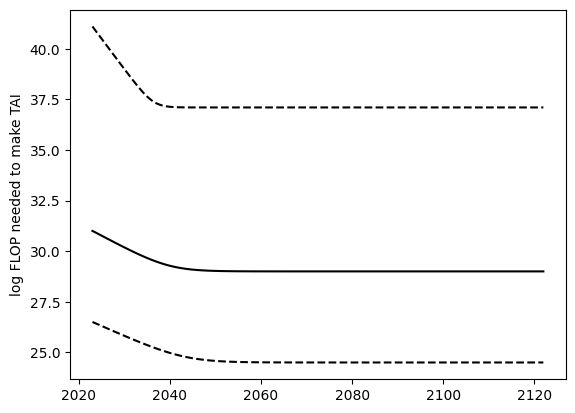

Year: 2023 - log FLOP needed for TAI 31.0 (~10 nonillion) 90% CI 26.5 (~316 septillion) - 41.1 (~126 million decillion)
Year: 2024 - log FLOP needed for TAI 30.9 (~8 nonillion) 90% CI 26.4 (~254 septillion) - 40.8 (~63 million decillion)
Year: 2025 - log FLOP needed for TAI 30.8 (~6 nonillion) 90% CI 26.3 (~202 septillion) - 40.5 (~31 million decillion)
Year: 2026 - log FLOP needed for TAI 30.6 (~4 nonillion) 90% CI 26.2 (~161 septillion) - 40.2 (~16 million decillion)
Year: 2027 - log FLOP needed for TAI 30.5 (~3 nonillion) 90% CI 26.1 (~129 septillion) - 39.9 (~8 million decillion)
Year: 2028 - log FLOP needed for TAI 30.4 (~3 nonillion) 90% CI 26.0 (~103 septillion) - 39.6 (~4 million decillion)
Year: 2029 - log FLOP needed for TAI 30.3 (~2 nonillion) 90% CI 25.9 (~82 septillion) - 39.3 (~2 million decillion)
Year: 2030 - log FLOP needed for TAI 30.2 (~2 nonillion) 90% CI 25.8 (~66 septillion) - 39.0 (~996 thousand decillion)
Year: 2031 - log FLOP needed for TAI 30.1 (~1 nonillion) 

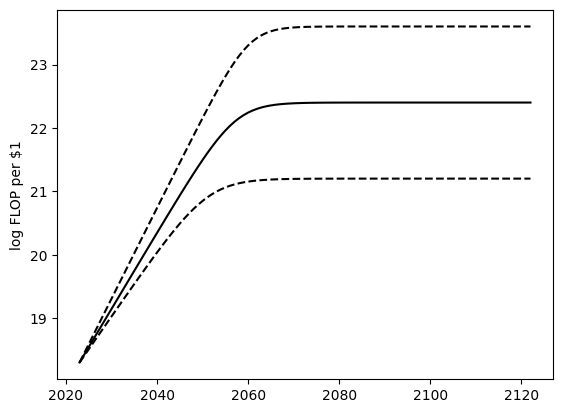

Year: 2023 - log FLOP per 2022$1USD 18.3 (~2 quintillion) 90% CI 18.3 (~2 quintillion) - 18.3 (~2 quintillion)
Year: 2024 - log FLOP per 2022$1USD 18.4 (~3 quintillion) 90% CI 18.4 (~3 quintillion) - 18.4 (~3 quintillion)
Year: 2025 - log FLOP per 2022$1USD 18.5 (~3 quintillion) 90% CI 18.5 (~3 quintillion) - 18.6 (~4 quintillion)
Year: 2026 - log FLOP per 2022$1USD 18.7 (~5 quintillion) 90% CI 18.6 (~4 quintillion) - 18.7 (~5 quintillion)
Year: 2027 - log FLOP per 2022$1USD 18.8 (~6 quintillion) 90% CI 18.7 (~5 quintillion) - 18.9 (~7 quintillion)
Year: 2028 - log FLOP per 2022$1USD 18.9 (~8 quintillion) 90% CI 18.8 (~7 quintillion) - 19.0 (~10 quintillion)
Year: 2029 - log FLOP per 2022$1USD 19.0 (~11 quintillion) 90% CI 18.9 (~8 quintillion) - 19.2 (~14 quintillion)
Year: 2030 - log FLOP per 2022$1USD 19.1 (~14 quintillion) 90% CI 19.0 (~11 quintillion) - 19.3 (~20 quintillion)
Year: 2031 - log FLOP per 2022$1USD 19.3 (~18 quintillion) 90% CI 19.1 (~13 quintillion) - 19.4 (~28 quint

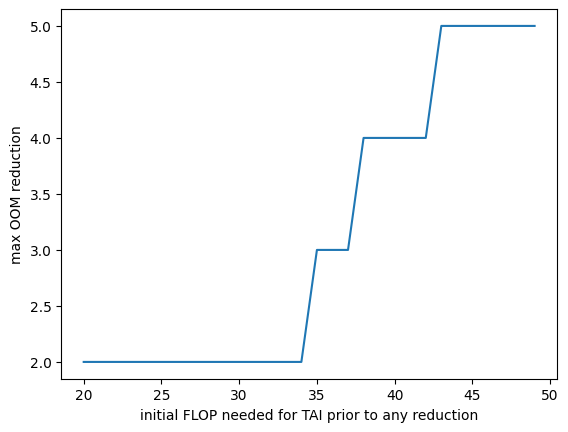

TAI log FLOP 20 -> 2.0 OOM reductions possible
TAI log FLOP 21 -> 2.0 OOM reductions possible
TAI log FLOP 22 -> 2.0 OOM reductions possible
TAI log FLOP 23 -> 2.0 OOM reductions possible
TAI log FLOP 24 -> 2.0 OOM reductions possible
TAI log FLOP 25 -> 2.0 OOM reductions possible
TAI log FLOP 26 -> 2.0 OOM reductions possible
TAI log FLOP 27 -> 2.0 OOM reductions possible
TAI log FLOP 28 -> 2.0 OOM reductions possible
TAI log FLOP 29 -> 2.0 OOM reductions possible
TAI log FLOP 30 -> 2.0 OOM reductions possible
TAI log FLOP 31 -> 2.0 OOM reductions possible
TAI log FLOP 32 -> 2.0 OOM reductions possible
TAI log FLOP 33 -> 2.0 OOM reductions possible
TAI log FLOP 34 -> 2.0 OOM reductions possible
TAI log FLOP 35 -> 3.0 OOM reductions possible
TAI log FLOP 36 -> 3.0 OOM reductions possible
TAI log FLOP 37 -> 3.0 OOM reductions possible
TAI log FLOP 38 -> 4.0 OOM reductions possible
TAI log FLOP 39 -> 4.0 OOM reductions possible
TAI log FLOP 40 -> 4.0 OOM reductions possible
TAI log FLOP 

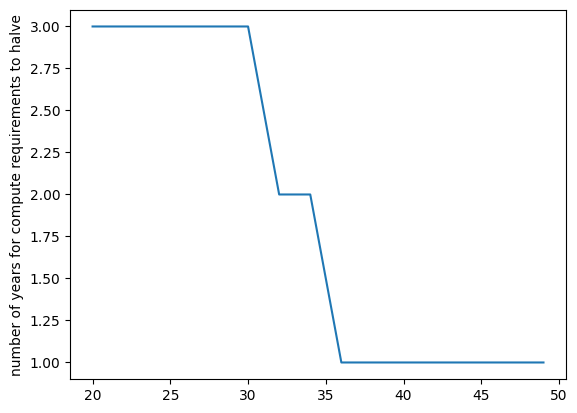

TAI log FLOP 20 -> algo doubling rate 3.0yrs
TAI log FLOP 21 -> algo doubling rate 3.0yrs
TAI log FLOP 22 -> algo doubling rate 3.0yrs
TAI log FLOP 23 -> algo doubling rate 3.0yrs
TAI log FLOP 24 -> algo doubling rate 3.0yrs
TAI log FLOP 25 -> algo doubling rate 3.0yrs
TAI log FLOP 26 -> algo doubling rate 3.0yrs
TAI log FLOP 27 -> algo doubling rate 3.0yrs
TAI log FLOP 28 -> algo doubling rate 3.0yrs
TAI log FLOP 29 -> algo doubling rate 3.0yrs
TAI log FLOP 30 -> algo doubling rate 3.0yrs
TAI log FLOP 31 -> algo doubling rate 2.5yrs
TAI log FLOP 32 -> algo doubling rate 2.0yrs
TAI log FLOP 33 -> algo doubling rate 2.0yrs
TAI log FLOP 34 -> algo doubling rate 2.0yrs
TAI log FLOP 35 -> algo doubling rate 1.5yrs
TAI log FLOP 36 -> algo doubling rate 1.0yrs
TAI log FLOP 37 -> algo doubling rate 1.0yrs
TAI log FLOP 38 -> algo doubling rate 1.0yrs
TAI log FLOP 39 -> algo doubling rate 1.0yrs
TAI log FLOP 40 -> algo doubling rate 1.0yrs
TAI log FLOP 41 -> algo doubling rate 1.0yrs
TAI log FL

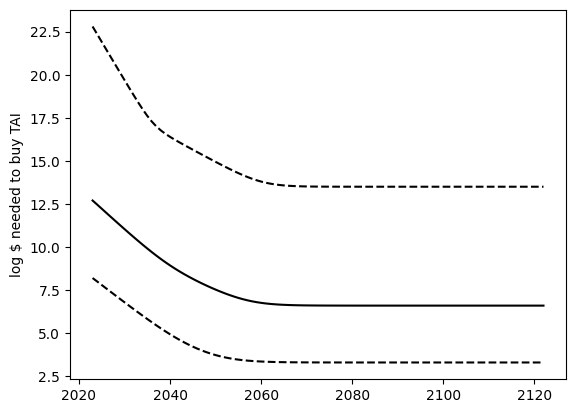

Year: 2023 - 12.7 log 2022$USD to buy TAI (~5 trillion) 90% CI 8.2 (~159 million) - 22.8 (~63 sextillion)
Year: 2024 - 12.5 log 2022$USD to buy TAI (~3 trillion) 90% CI 8.0 (~100 million) - 22.4 (~23 sextillion)
Year: 2025 - 12.2 log 2022$USD to buy TAI (~2 trillion) 90% CI 7.8 (~63 million) - 21.9 (~8 sextillion)
Year: 2026 - 12.0 log 2022$USD to buy TAI (~972 billion) 90% CI 7.6 (~40 million) - 21.5 (~3 sextillion)
Year: 2027 - 11.7 log 2022$USD to buy TAI (~562 billion) 90% CI 7.4 (~25 million) - 21.0 (~1 sextillion)
Year: 2028 - 11.5 log 2022$USD to buy TAI (~326 billion) 90% CI 7.2 (~16 million) - 20.6 (~380 quintillion)
Year: 2029 - 11.3 log 2022$USD to buy TAI (~189 billion) 90% CI 7.0 (~10 million) - 20.1 (~137 quintillion)
Year: 2030 - 11.0 log 2022$USD to buy TAI (~111 billion) 90% CI 6.8 (~6 million) - 19.7 (~50 quintillion)
Year: 2031 - 10.8 log 2022$USD to buy TAI (~65 billion) 90% CI 6.6 (~4 million) - 19.3 (~18 quintillion)
Year: 2032 - 10.6 log 2022$USD to buy TAI (~38 

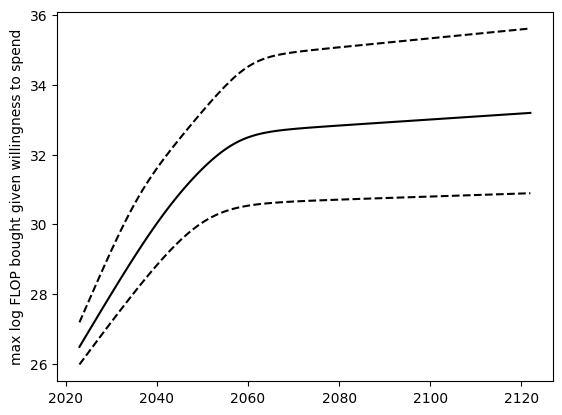

Year: 2023 - max log FLOP 26.5 (~311 septillion) 90% CI 26.0 (~97 septillion) - 27.2 (~2 octillion)
Year: 2024 - max log FLOP 26.7 (~514 septillion) 90% CI 26.2 (~146 septillion) - 27.5 (~3 octillion)
Year: 2025 - max log FLOP 26.9 (~850 septillion) 90% CI 26.3 (~218 septillion) - 27.8 (~6 octillion)
Year: 2026 - max log FLOP 27.1 (~1 octillion) 90% CI 26.5 (~325 septillion) - 28.1 (~12 octillion)
Year: 2027 - max log FLOP 27.4 (~2 octillion) 90% CI 26.7 (~485 septillion) - 28.4 (~24 octillion)
Year: 2028 - max log FLOP 27.6 (~4 octillion) 90% CI 26.9 (~723 septillion) - 28.7 (~47 octillion)
Year: 2029 - max log FLOP 27.8 (~6 octillion) 90% CI 27.0 (~1 octillion) - 29.0 (~93 octillion)
Year: 2030 - max log FLOP 28.0 (~10 octillion) 90% CI 27.2 (~2 octillion) - 29.3 (~178 octillion)
Year: 2031 - max log FLOP 28.2 (~17 octillion) 90% CI 27.4 (~2 octillion) - 29.5 (~340 octillion)
Year: 2032 - max log FLOP 28.4 (~27 octillion) 90% CI 27.5 (~3 octillion) - 29.8 (~636 octillion)
Year: 2033 

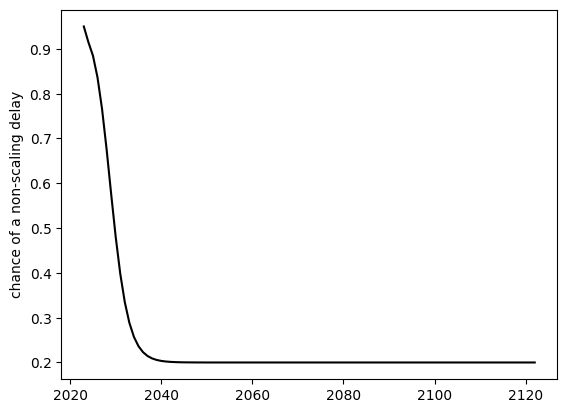

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 95%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 91%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 89%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 84%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 77%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 68%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 58%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 48%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 40%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 33%
Year: 2033

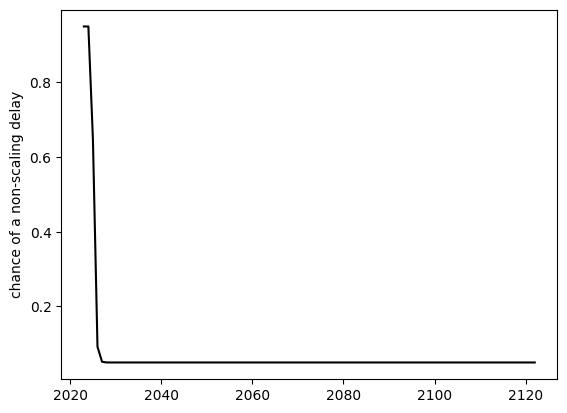

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 95%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 95%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 65%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 9%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2033 - chan

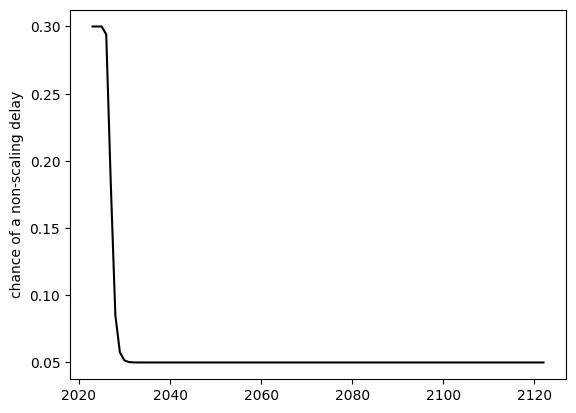

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 29%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 18%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 9%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 6%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2033 - ch

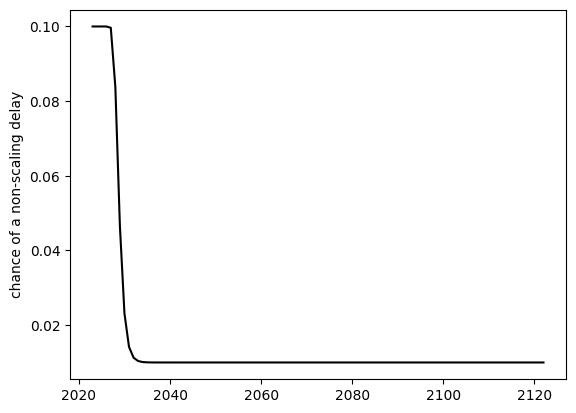

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 8%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 5%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 2%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 1%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 1%
Year: 2033 - ch

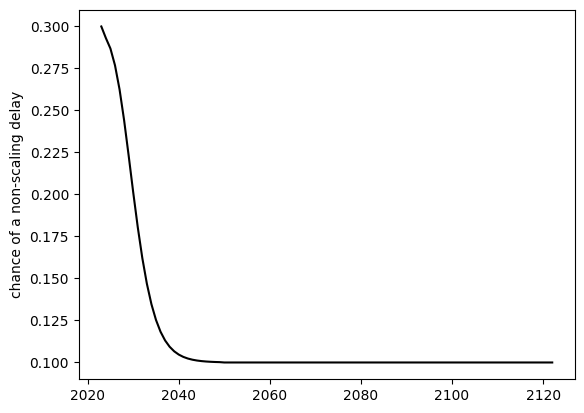

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 29%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 29%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 28%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 26%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 24%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 22%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 20%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 18%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 16%
Year: 2033

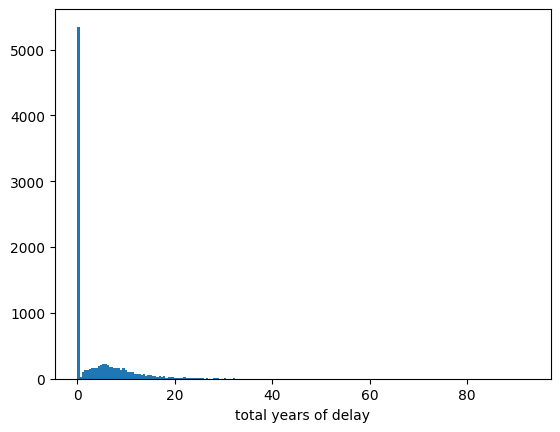

In [7]:
variables['RUNS'] = RUNS
variables['CURRENT_YEAR'] = CURRENT_YEAR
variables['MAX_YEAR'] = MAX_YEAR
run_timelines_model(variables,
                    cores=1,
                    runs=variables['RUNS'],
                    #dump_cache_file='caches/tai_years_metaculus_parity')
                    dump_cache_file='caches/tai_years')


-
-
## SAMPLE RUN 4 ##
It takes 26.6 log FLOP (~398 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 1.9 years they get 2x cheaper, to a maximum of 23.3 log FLOP (~182 sextillion) per 2022$USD.
We are initially willing to pay 8.0 log 2022$USD (~100 million). This doubles every 1.0 years until 2025, and then doubles every 2.5 years to a max of 0.001693% of GDP. GDP grows at a rate of 1.031x per year.
---
Year: 2023 - 26.3 max log FLOP (199 septillion) available - TAI takes 26.6 log FLOP (398 septillion) - log $ 8.3 to buy TAI (200 million) vs. willingness to pay log $ 8.0 (100 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.8 max log FLOP (571 septillion) available - TAI takes 26.5 log FLOP (320 septillion) - log $ 8.0 to buy TAI (111 million) vs. willingness to pay log $ 8.3 (199 million) - 18.5 log FLOP per $ (3 quintillion)
-- a

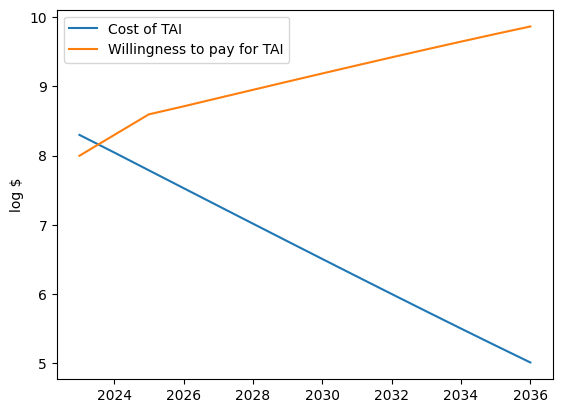

-
-
## SAMPLE RUN 5 ##
It takes 29.2 log FLOP (~158 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.2 years they get 2x cheaper, to a maximum of 21.1 log FLOP (~1 sextillion) per 2022$USD.
We are initially willing to pay 7.3 log 2022$USD (~20 million). This doubles every 1.0 years until 2025, and then doubles every 1.8 years to a max of 9.5e-05% of GDP. GDP grows at a rate of 1.031x per year.
---
Year: 2023 - 25.6 max log FLOP (39 septillion) available - TAI takes 29.2 log FLOP (158 octillion) - log $ 10.9 to buy TAI (80 billion) vs. willingness to pay log $ 7.3 (20 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.0 max log FLOP (109 septillion) available - TAI takes 29.1 log FLOP (127 octillion) - log $ 10.7 to buy TAI (47 billion) vs. willingness to pay log $ 7.6 (40 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 -

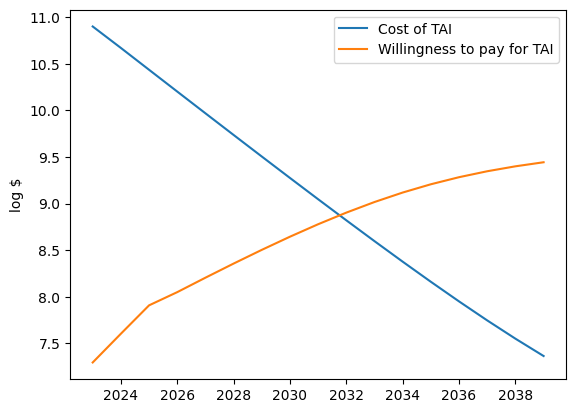

-
-
## SAMPLE RUN 6 ##
It takes 29.2 log FLOP (~158 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.4 years they get 2x cheaper, to a maximum of 21.7 log FLOP (~5 sextillion) per 2022$USD.
We are initially willing to pay 8.2 log 2022$USD (~158 million). This doubles every 1.0 years until 2025, and then doubles every 2.6 years to a max of 0.000933% of GDP. GDP grows at a rate of 1.02x per year.
---
Year: 2023 - 26.5 max log FLOP (314 septillion) available - TAI takes 29.2 log FLOP (158 octillion) - log $ 10.9 to buy TAI (79 billion) vs. willingness to pay log $ 8.2 (157 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.9 max log FLOP (844 septillion) available - TAI takes 29.1 log FLOP (127 octillion) - log $ 10.7 to buy TAI (48 billion) vs. willingness to pay log $ 8.5 (316 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 20

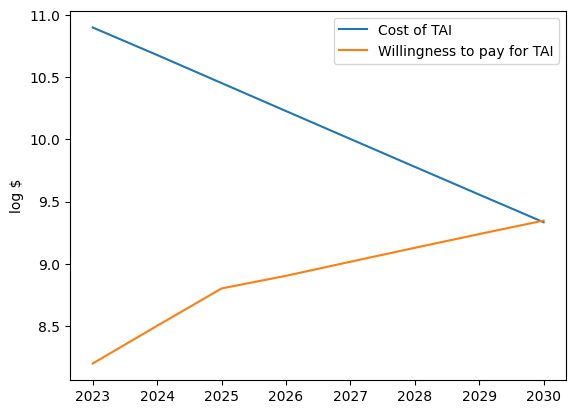

-
-
## SAMPLE RUN 7 ##
It takes 41.5 log FLOP (~316 million decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 4 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.2 years they get 2x cheaper, to a maximum of 22.2 log FLOP (~14 sextillion) per 2022$USD.
We are initially willing to pay 7.9 log 2022$USD (~79 million). This doubles every 1.0 years until 2025, and then doubles every 5.1 years to a max of 0.001922% of GDP. GDP grows at a rate of 1.032x per year.
---
Year: 2023 - 26.2 max log FLOP (158 septillion) available - TAI takes 41.5 log FLOP (316 million decillion) - log $ 23.2 to buy TAI (159 sextillion) vs. willingness to pay log $ 7.9 (79 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.6 max log FLOP (444 septillion) available - TAI takes 41.2 log FLOP (158 million decillion) - log $ 22.8 to buy TAI (58 sextillion) vs. willingness to pay log $ 8.2 (163 million) - 18.4 log FLOP p

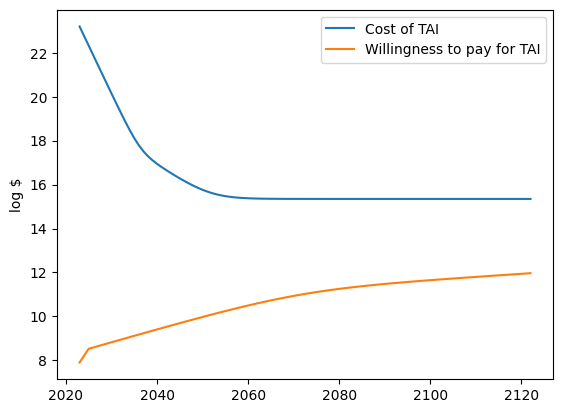

-
-
## SAMPLE RUN 8 ##
It takes 36.9 log FLOP (~8 thousand decillion) for transformative capabilities.
Every 1.0 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.1 years they get 2x cheaper, to a maximum of 23.6 log FLOP (~414 sextillion) per 2022$USD.
We are initially willing to pay 8.1 log 2022$USD (~126 million). This doubles every 0.9 years until 2025, and then doubles every 3.4 years to a max of 0.000193% of GDP. GDP grows at a rate of 1.027x per year.
---
Year: 2023 - 26.4 max log FLOP (244 septillion) available - TAI takes 36.9 log FLOP (8 thousand decillion) - log $ 18.6 to buy TAI (4 quintillion) vs. willingness to pay log $ 8.1 (122 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.8 max log FLOP (695 septillion) available - TAI takes 36.6 log FLOP (4 thousand decillion) - log $ 18.2 to buy TAI (1 quintillion) vs. willingness to pay log $ 8.4 (250 million) - 18.4 log FLOP 

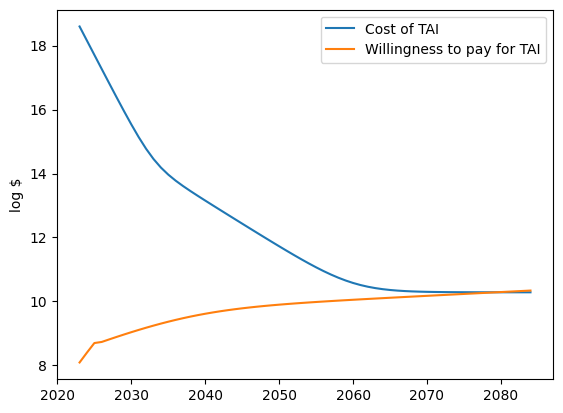

-
-
## SAMPLE RUN 9 ##
It takes 28.6 log FLOP (~40 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.2 years they get 2x cheaper, to a maximum of 22.3 log FLOP (~18 sextillion) per 2022$USD.
We are initially willing to pay 8.6 log 2022$USD (~398 million). This doubles every 1.0 years until 2025, and then doubles every 4.1 years to a max of 0.001656% of GDP. GDP grows at a rate of 1.026x per year.
---
Year: 2023 - 26.9 max log FLOP (786 septillion) available - TAI takes 28.6 log FLOP (40 octillion) - log $ 10.3 to buy TAI (20 billion) vs. willingness to pay log $ 8.6 (394 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 27.3 max log FLOP (2 octillion) available - TAI takes 28.5 log FLOP (32 octillion) - log $ 10.1 to buy TAI (12 billion) vs. willingness to pay log $ 8.9 (801 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 -

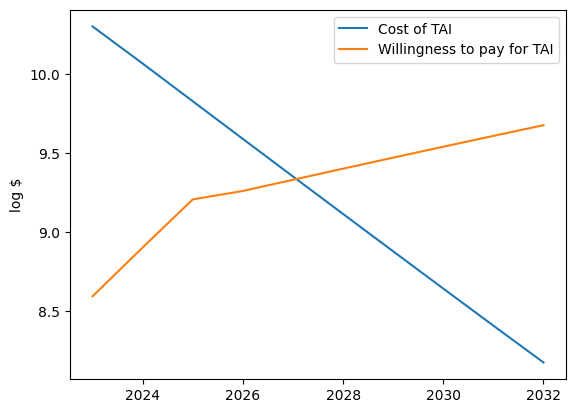

-
-
## SAMPLE RUN 10 ##
It takes 27.9 log FLOP (~8 octillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 3.1 years they get 2x cheaper, to a maximum of 24.1 log FLOP (~1 septillion) per 2022$USD.
We are initially willing to pay 8.1 log 2022$USD (~126 million). This doubles every 1.0 years until 2025, and then doubles every 2.3 years to a max of 0.001557% of GDP. GDP grows at a rate of 1.023x per year.
---
Year: 2023 - 26.4 max log FLOP (250 septillion) available - TAI takes 27.9 log FLOP (8 octillion) - log $ 9.6 to buy TAI (4 billion) vs. willingness to pay log $ 8.1 (125 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.8 max log FLOP (628 septillion) available - TAI takes 27.8 log FLOP (6 octillion) - log $ 9.4 to buy TAI (3 billion) vs. willingness to pay log $ 8.4 (251 million) - 18.4 log FLOP per $ (2 quintillion)
Year: 2025 - 27.2 

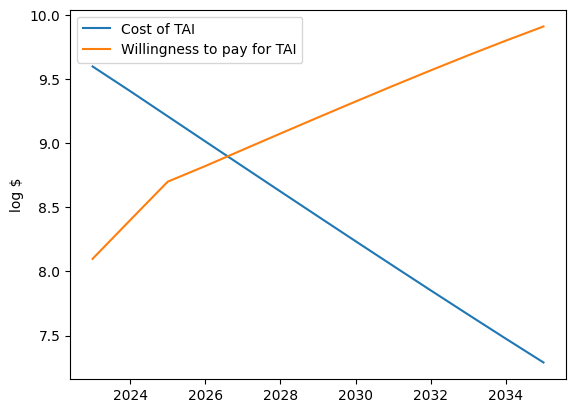

-
-
## SAMPLE RUN 11 ##
It takes 39.8 log FLOP (~6 million decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 4 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.6 years they get 2x cheaper, to a maximum of 22.3 log FLOP (~19 sextillion) per 2022$USD.
We are initially willing to pay 8.5 log 2022$USD (~316 million). This doubles every 1.0 years until 2025, and then doubles every 3.1 years to a max of 0.000262% of GDP. GDP grows at a rate of 1.023x per year.
---
Year: 2023 - 26.8 max log FLOP (599 septillion) available - TAI takes 39.8 log FLOP (6 million decillion) - log $ 21.5 to buy TAI (3 sextillion) vs. willingness to pay log $ 8.5 (300 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 27.2 max log FLOP (1 octillion) available - TAI takes 39.5 log FLOP (3 million decillion) - log $ 21.1 to buy TAI (1 sextillion) vs. willingness to pay log $ 8.8 (565 million) - 18.4 log FLOP per $ (3 q

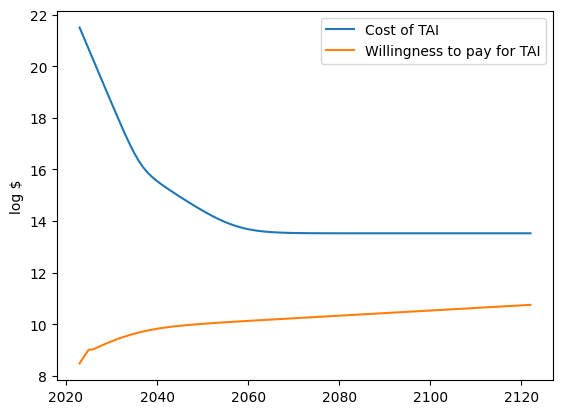

-
-
## SAMPLE RUN 12 ##
It takes 27.1 log FLOP (~1 octillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.2 years they get 2x cheaper, to a maximum of 20.7 log FLOP (~552 quintillion) per 2022$USD.
We are initially willing to pay 8.1 log 2022$USD (~126 million). This doubles every 1.0 years until 2025, and then doubles every 3.5 years to a max of 0.014808% of GDP. GDP grows at a rate of 1.012x per year.
---
Year: 2023 - 26.4 max log FLOP (250 septillion) available - TAI takes 27.1 log FLOP (1 octillion) - log $ 8.8 to buy TAI (633 million) vs. willingness to pay log $ 8.1 (126 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.8 max log FLOP (674 septillion) available - TAI takes 27.0 log FLOP (1 octillion) - log $ 8.6 to buy TAI (373 million) vs. willingness to pay log $ 8.4 (249 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 

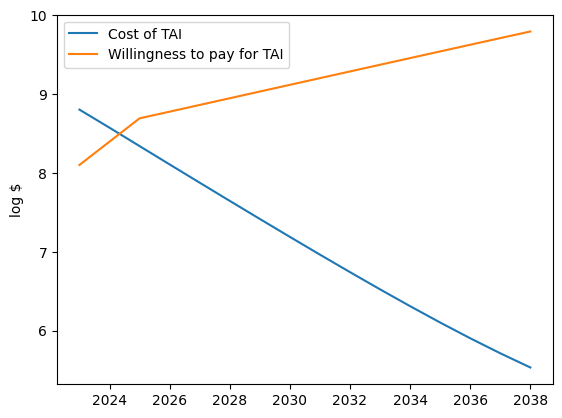

-
-
## SAMPLE RUN 13 ##
It takes 35.9 log FLOP (~794 decillion) for transformative capabilities.
Every 1.5 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.6 years they get 2x cheaper, to a maximum of 22.8 log FLOP (~58 sextillion) per 2022$USD.
We are initially willing to pay 7.9 log 2022$USD (~79 million). This doubles every 1.0 years until 2025, and then doubles every 2.8 years to a max of 0.000879% of GDP. GDP grows at a rate of 1.024x per year.
---
Year: 2023 - 26.2 max log FLOP (158 septillion) available - TAI takes 35.9 log FLOP (794 decillion) - log $ 17.6 to buy TAI (398 quadrillion) vs. willingness to pay log $ 7.9 (79 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.6 max log FLOP (415 septillion) available - TAI takes 35.7 log FLOP (501 decillion) - log $ 17.3 to buy TAI (192 quadrillion) vs. willingness to pay log $ 8.2 (159 million) - 18.4 log FLOP per $ (3 quintillio

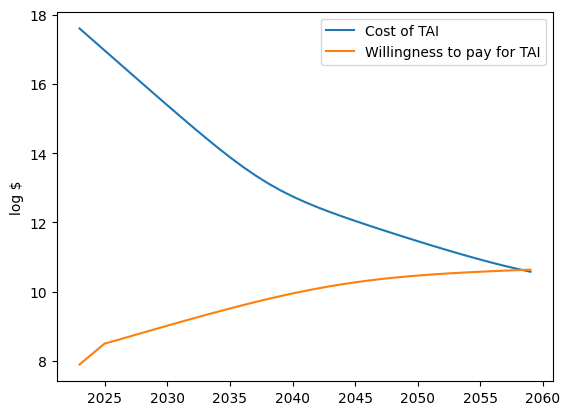

-
-
## SAMPLE RUN 14 ##
It takes 27.5 log FLOP (~3 octillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.4 years they get 2x cheaper, to a maximum of 22.7 log FLOP (~50 sextillion) per 2022$USD.
We are initially willing to pay 8.0 log 2022$USD (~100 million). This doubles every 1.0 years until 2025, and then doubles every 4.1 years to a max of 0.000238% of GDP. GDP grows at a rate of 1.033x per year.
---
Year: 2023 - 26.3 max log FLOP (196 septillion) available - TAI takes 27.5 log FLOP (3 octillion) - log $ 9.2 to buy TAI (2 billion) vs. willingness to pay log $ 8.0 (98 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.7 max log FLOP (505 septillion) available - TAI takes 27.4 log FLOP (3 octillion) - log $ 9.0 to buy TAI (951 million) vs. willingness to pay log $ 8.3 (189 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 27.

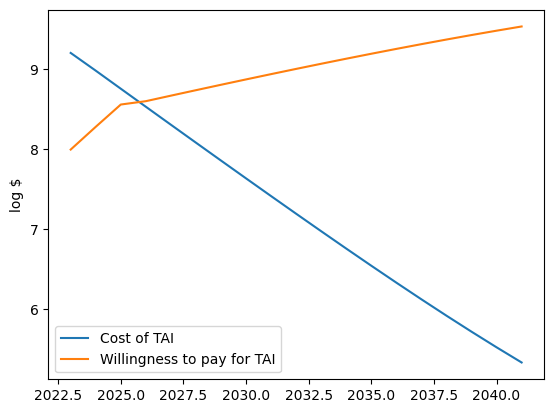

-
-
## SAMPLE RUN 15 ##
It takes 38.5 log FLOP (~316 thousand decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 4 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.5 years they get 2x cheaper, to a maximum of 22.7 log FLOP (~49 sextillion) per 2022$USD.
We are initially willing to pay 8.3 log 2022$USD (~200 million). This doubles every 1.0 years until 2025, and then doubles every 4.6 years to a max of 0.000328% of GDP. GDP grows at a rate of 1.022x per year.
---
Year: 2023 - 26.6 max log FLOP (388 septillion) available - TAI takes 38.5 log FLOP (316 thousand decillion) - log $ 20.2 to buy TAI (158 quintillion) vs. willingness to pay log $ 8.3 (194 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 27.0 max log FLOP (983 septillion) available - TAI takes 38.2 log FLOP (158 thousand decillion) - log $ 19.8 to buy TAI (60 quintillion) vs. willingness to pay log $ 8.6 (372 million) - 18.4 lo

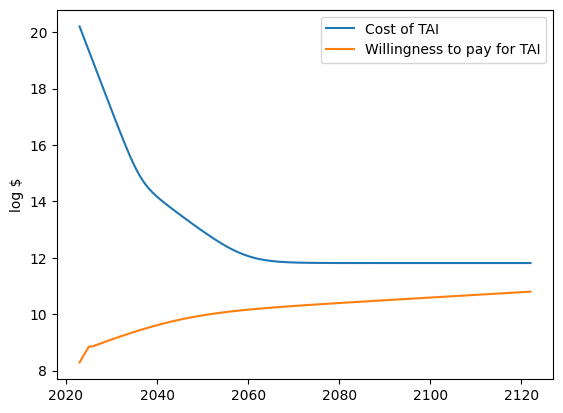

-
-
## SAMPLE RUN 16 ##
It takes 28.1 log FLOP (~13 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.9 years they get 2x cheaper, to a maximum of 23.0 log FLOP (~104 sextillion) per 2022$USD.
We are initially willing to pay 8.8 log 2022$USD (~631 million). This doubles every 1.0 years until 2025, and then doubles every 1.8 years to a max of 0.000414% of GDP. GDP grows at a rate of 1.011x per year.
---
Year: 2023 - 27.1 max log FLOP (1 octillion) available - TAI takes 28.1 log FLOP (13 octillion) - log $ 9.8 to buy TAI (6 billion) vs. willingness to pay log $ 8.8 (592 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 27.5 max log FLOP (3 octillion) available - TAI takes 28.0 log FLOP (10 octillion) - log $ 9.6 to buy TAI (4 billion) vs. willingness to pay log $ 9.0 (1 billion) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 27.8 m

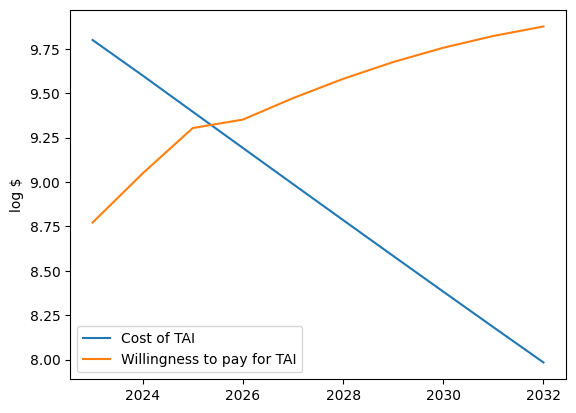

-
-
## SAMPLE RUN 17 ##
It takes 29.3 log FLOP (~200 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.6 years they get 2x cheaper, to a maximum of 21.5 log FLOP (~3 sextillion) per 2022$USD.
We are initially willing to pay 9.2 log 2022$USD (~2 billion). This doubles every 1.0 years until 2025, and then doubles every 3.8 years to a max of 0.001325% of GDP. GDP grows at a rate of 1.017x per year.
---
Year: 2023 - 27.5 max log FLOP (3 octillion) available - TAI takes 29.3 log FLOP (200 octillion) - log $ 11.0 to buy TAI (100 billion) vs. willingness to pay log $ 9.2 (2 billion) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 27.9 max log FLOP (8 octillion) available - TAI takes 29.2 log FLOP (160 octillion) - log $ 10.8 to buy TAI (62 billion) vs. willingness to pay log $ 9.5 (3 billion) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 28.3

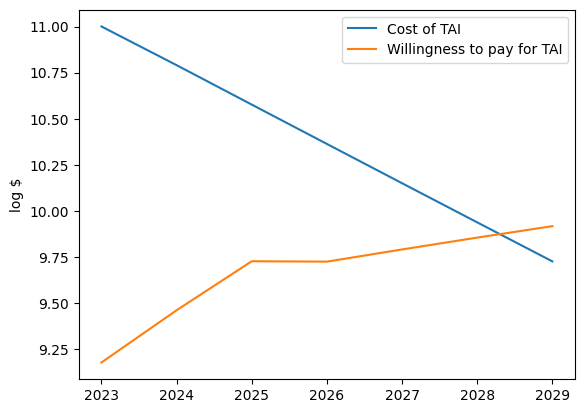

-
-
## SAMPLE RUN 18 ##
It takes 31.7 log FLOP (~50 nonillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.3 years they get 2x cheaper, to a maximum of 24.1 log FLOP (~1 septillion) per 2022$USD.
We are initially willing to pay 8.5 log 2022$USD (~316 million). This doubles every 1.0 years until 2025, and then doubles every 3.1 years to a max of 0.000265% of GDP. GDP grows at a rate of 1.027x per year.
---
Year: 2023 - 26.8 max log FLOP (600 septillion) available - TAI takes 31.7 log FLOP (50 nonillion) - log $ 13.4 to buy TAI (25 trillion) vs. willingness to pay log $ 8.5 (301 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 27.2 max log FLOP (2 octillion) available - TAI takes 31.6 log FLOP (38 nonillion) - log $ 13.2 to buy TAI (14 trillion) vs. willingness to pay log $ 8.8 (585 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025

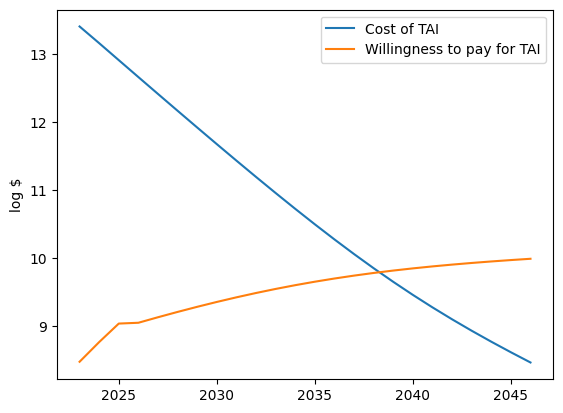

-
-
## SAMPLE RUN 19 ##
It takes 36.4 log FLOP (~3 thousand decillion) for transformative capabilities.
Every 1.0 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.4 years they get 2x cheaper, to a maximum of 22.2 log FLOP (~15 sextillion) per 2022$USD.
We are initially willing to pay 8.7 log 2022$USD (~501 million). This doubles every 1.0 years until 2025, and then doubles every 3.3 years to a max of 0.000577% of GDP. GDP grows at a rate of 1.018x per year.
---
Year: 2023 - 27.0 max log FLOP (964 septillion) available - TAI takes 36.4 log FLOP (3 thousand decillion) - log $ 18.1 to buy TAI (1 quintillion) vs. willingness to pay log $ 8.7 (483 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 27.4 max log FLOP (2 octillion) available - TAI takes 36.1 log FLOP (1 thousand decillion) - log $ 17.7 to buy TAI (474 quadrillion) vs. willingness to pay log $ 9.0 (941 million) - 18.4 log FLOP p

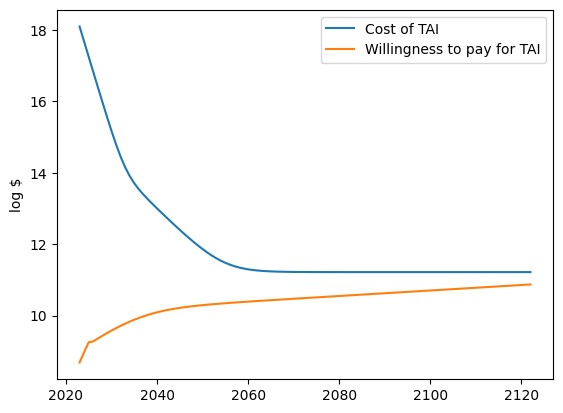

-
-
## SAMPLE RUN 20 ##
It takes 33.2 log FLOP (~2 decillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.4 years they get 2x cheaper, to a maximum of 22.2 log FLOP (~15 sextillion) per 2022$USD.
We are initially willing to pay 7.7 log 2022$USD (~50 million). This doubles every 1.0 years until 2025, and then doubles every 1.8 years to a max of 0.001182% of GDP. GDP grows at a rate of 1.01x per year.
---
Year: 2023 - 26.0 max log FLOP (100 septillion) available - TAI takes 33.2 log FLOP (2 decillion) - log $ 14.9 to buy TAI (794 trillion) vs. willingness to pay log $ 7.7 (50 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.4 max log FLOP (265 septillion) available - TAI takes 33.1 log FLOP (1 decillion) - log $ 14.6 to buy TAI (427 trillion) vs. willingness to pay log $ 8.0 (99 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 

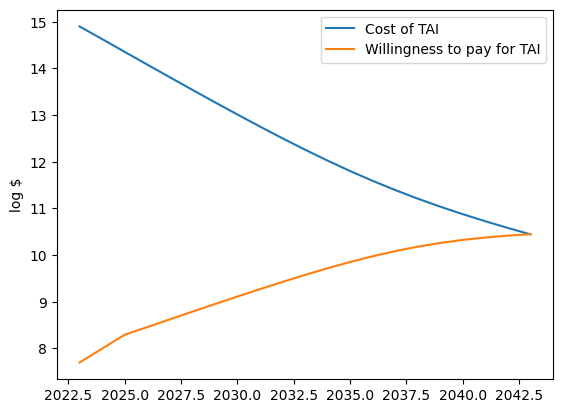

-
-
## SAMPLE RUN 21 ##
It takes 27.4 log FLOP (~3 octillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.7 years they get 2x cheaper, to a maximum of 22.7 log FLOP (~47 sextillion) per 2022$USD.
We are initially willing to pay 7.6 log 2022$USD (~40 million). This doubles every 1.0 years until 2025, and then doubles every 3.5 years to a max of 0.000735% of GDP. GDP grows at a rate of 1.023x per year.
---
Year: 2023 - 25.9 max log FLOP (79 septillion) available - TAI takes 27.4 log FLOP (3 octillion) - log $ 9.1 to buy TAI (1 billion) vs. willingness to pay log $ 7.6 (40 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.3 max log FLOP (210 septillion) available - TAI takes 27.3 log FLOP (2 octillion) - log $ 8.9 to buy TAI (784 million) vs. willingness to pay log $ 7.9 (82 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.7 m

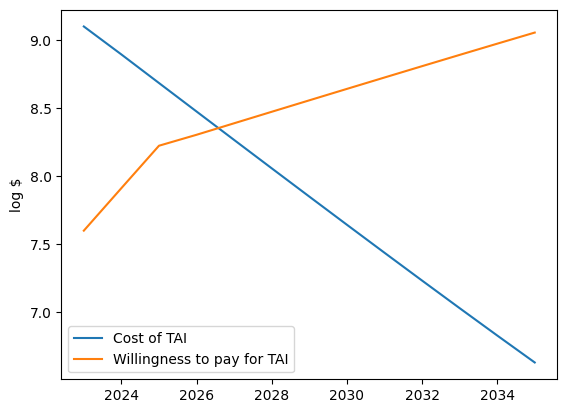

-
-
## SAMPLE RUN 22 ##
It takes 29.5 log FLOP (~316 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.5 years they get 2x cheaper, to a maximum of 21.0 log FLOP (~1 sextillion) per 2022$USD.
We are initially willing to pay 8.6 log 2022$USD (~398 million). This doubles every 1.0 years until 2025, and then doubles every 2.9 years to a max of 4.6e-05% of GDP. GDP grows at a rate of 1.014x per year.
---
Year: 2023 - 26.8 max log FLOP (577 septillion) available - TAI takes 29.5 log FLOP (316 octillion) - log $ 11.2 to buy TAI (159 billion) vs. willingness to pay log $ 8.5 (290 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 27.1 max log FLOP (1 octillion) available - TAI takes 29.4 log FLOP (254 octillion) - log $ 11.0 to buy TAI (97 billion) vs. willingness to pay log $ 8.7 (468 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 202

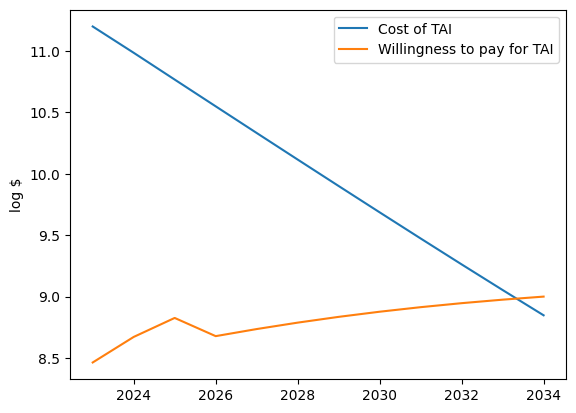

-
-
## SAMPLE RUN 23 ##
It takes 32.9 log FLOP (~794 nonillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.9 years they get 2x cheaper, to a maximum of 20.5 log FLOP (~283 quintillion) per 2022$USD.
We are initially willing to pay 8.5 log 2022$USD (~316 million). This doubles every 1.0 years until 2025, and then doubles every 2.0 years to a max of 0.002197% of GDP. GDP grows at a rate of 1.031x per year.
---
Year: 2023 - 26.8 max log FLOP (623 septillion) available - TAI takes 32.9 log FLOP (794 nonillion) - log $ 14.6 to buy TAI (401 trillion) vs. willingness to pay log $ 8.5 (314 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 27.2 max log FLOP (2 octillion) available - TAI takes 32.8 log FLOP (570 nonillion) - log $ 14.4 to buy TAI (226 trillion) vs. willingness to pay log $ 8.8 (623 million) - 18.4 log FLOP per $ (3 quintillion)
Ye

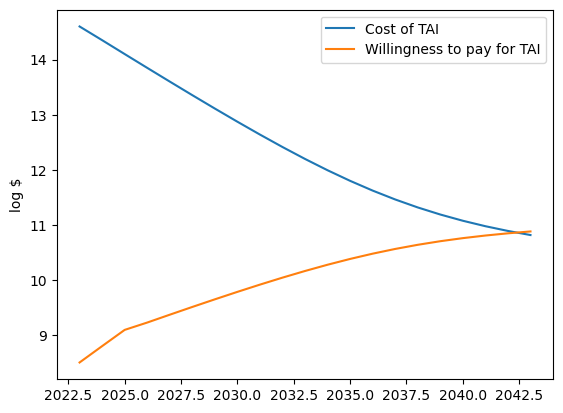

-
-
## SAMPLE RUN 24 ##
It takes 33.4 log FLOP (~3 decillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.6 years they get 2x cheaper, to a maximum of 23.2 log FLOP (~148 sextillion) per 2022$USD.
We are initially willing to pay 8.4 log 2022$USD (~251 million). This doubles every 1.0 years until 2025, and then doubles every 2.7 years to a max of 4.4e-05% of GDP. GDP grows at a rate of 1.039x per year.
---
Year: 2023 - 26.6 max log FLOP (401 septillion) available - TAI takes 33.4 log FLOP (3 decillion) - log $ 15.1 to buy TAI (1 quadrillion) vs. willingness to pay log $ 8.3 (201 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.9 max log FLOP (886 septillion) available - TAI takes 33.3 log FLOP (2 decillion) - log $ 14.8 to buy TAI (689 trillion) vs. willingness to pay log $ 8.5 (339 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 

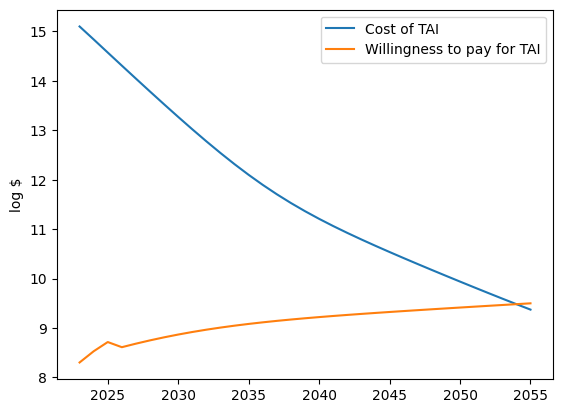

-
-
## SAMPLE RUN 25 ##
It takes 49.3 log FLOP (~20 quadrillion decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 5 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.7 years they get 2x cheaper, to a maximum of 22.5 log FLOP (~30 sextillion) per 2022$USD.
We are initially willing to pay 7.5 log 2022$USD (~32 million). This doubles every 0.9 years until 2025, and then doubles every 2.2 years to a max of 0.004896% of GDP. GDP grows at a rate of 1.008x per year.
---
Year: 2023 - 25.8 max log FLOP (63 septillion) available - TAI takes 49.3 log FLOP (20 quadrillion decillion) - log $ 31.0 to buy TAI (10 nonillion) vs. willingness to pay log $ 7.5 (32 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.2 max log FLOP (171 septillion) available - TAI takes 49.0 log FLOP (10 quadrillion decillion) - log $ 30.6 to buy TAI (4 nonillion) vs. willingness to pay log $ 7.8 (67 million) - 18.4 log FL

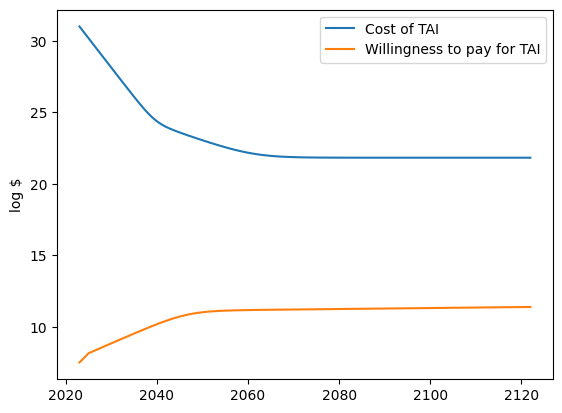

-
-
## SAMPLE RUN 26 ##
It takes 32.7 log FLOP (~501 nonillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.5 years they get 2x cheaper, to a maximum of 22.4 log FLOP (~25 sextillion) per 2022$USD.
We are initially willing to pay 7.6 log 2022$USD (~40 million). This doubles every 1.0 years until 2025, and then doubles every 1.6 years to a max of 0.000477% of GDP. GDP grows at a rate of 1.026x per year.
---
Year: 2023 - 25.9 max log FLOP (79 septillion) available - TAI takes 32.7 log FLOP (501 nonillion) - log $ 14.4 to buy TAI (251 trillion) vs. willingness to pay log $ 7.6 (40 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.3 max log FLOP (203 septillion) available - TAI takes 32.6 log FLOP (359 nonillion) - log $ 14.1 to buy TAI (137 trillion) vs. willingness to pay log $ 7.9 (77 million) - 18.4 log FLOP per $ (3 quintillion)
Year:

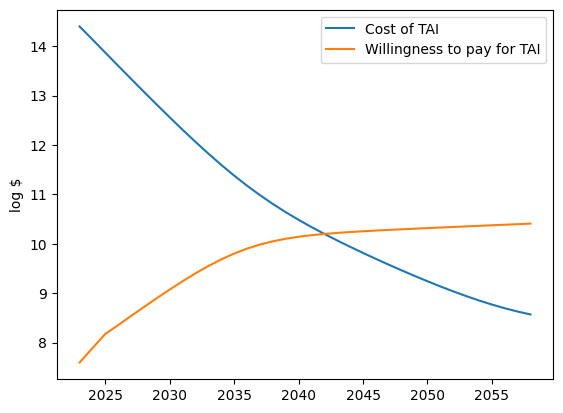

-
-
## SAMPLE RUN 27 ##
It takes 28.6 log FLOP (~40 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.7 years they get 2x cheaper, to a maximum of 23.7 log FLOP (~562 sextillion) per 2022$USD.
We are initially willing to pay 8.7 log 2022$USD (~501 million). This doubles every 1.0 years until 2025, and then doubles every 1 years to a max of 0.000549% of GDP. GDP grows at a rate of 1.021x per year.
---
Year: 2023 - 27.0 max log FLOP (962 septillion) available - TAI takes 28.6 log FLOP (40 octillion) - log $ 10.3 to buy TAI (20 billion) vs. willingness to pay log $ 8.7 (482 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 27.4 max log FLOP (2 octillion) available - TAI takes 28.5 log FLOP (32 octillion) - log $ 10.1 to buy TAI (12 billion) vs. willingness to pay log $ 9.0 (920 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 -

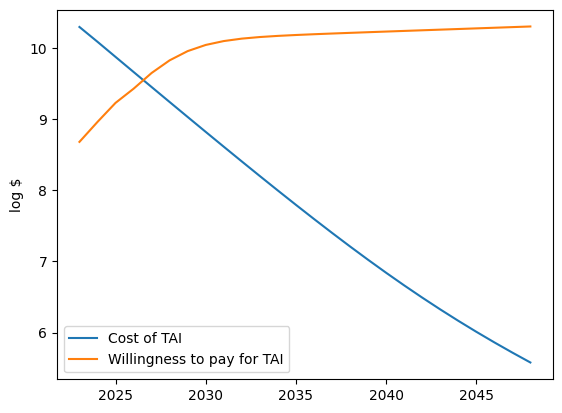

-
-
## SAMPLE RUN 28 ##
It takes 27.2 log FLOP (~2 octillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.6 years they get 2x cheaper, to a maximum of 21.7 log FLOP (~5 sextillion) per 2022$USD.
We are initially willing to pay 9.3 log 2022$USD (~2 billion). This doubles every 1.0 years until 2025, and then doubles every 3.6 years to a max of 0.000619% of GDP. GDP grows at a rate of 1.024x per year.
---
Year: 2023 - 27.5 max log FLOP (3 octillion) available - TAI takes 27.2 log FLOP (2 octillion) - log $ 8.9 to buy TAI (795 million) vs. willingness to pay log $ 9.2 (2 billion) - 18.3 log FLOP per $ (2 quintillion)
-- algorithms p_nonscaling_issue p=0.95 -> Nonscaling delay occured
-- -- delay is for +6 years
-- data p_nonscaling_issue p=0.95 -> Nonscaling delay occured
-- -- delay is for +5 years
-- robotics p_nonscaling_issue p=0.3 -> Nonscaling dela

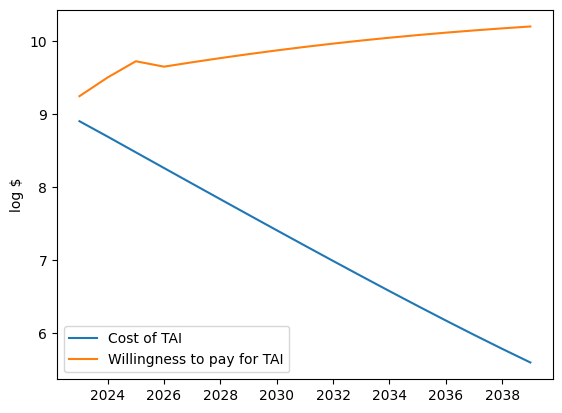

-
-
## SAMPLE RUN 29 ##
It takes 50.2 log FLOP (~158 quadrillion decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 5 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.6 years they get 2x cheaper, to a maximum of 22.1 log FLOP (~13 sextillion) per 2022$USD.
We are initially willing to pay 8.2 log 2022$USD (~158 million). This doubles every 1.0 years until 2025, and then doubles every 3.4 years to a max of 0.000356% of GDP. GDP grows at a rate of 1.011x per year.
---
Year: 2023 - 26.5 max log FLOP (310 septillion) available - TAI takes 50.2 log FLOP (158 quadrillion decillion) - log $ 31.9 to buy TAI (79 nonillion) vs. willingness to pay log $ 8.2 (155 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.9 max log FLOP (816 septillion) available - TAI takes 49.9 log FLOP (79 quadrillion decillion) - log $ 31.5 to buy TAI (30 nonillion) vs. willingness to pay log $ 8.5 (314 million) - 18.4

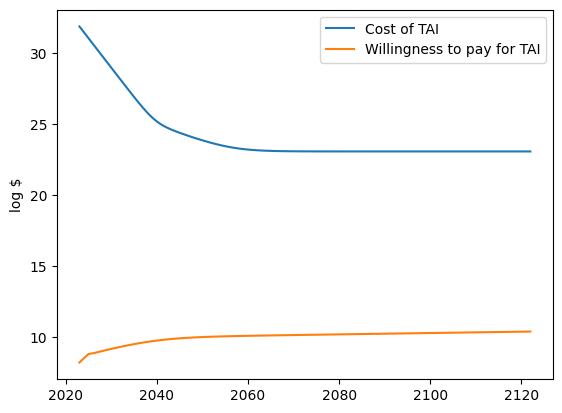

-
-
## SAMPLE RUN 30 ##
It takes 28.0 log FLOP (~10 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.8 years they get 2x cheaper, to a maximum of 22.7 log FLOP (~51 sextillion) per 2022$USD.
We are initially willing to pay 8.0 log 2022$USD (~100 million). This doubles every 1.0 years until 2025, and then doubles every 1.0 years to a max of 0.001483% of GDP. GDP grows at a rate of 1.032x per year.
---
Year: 2023 - 26.3 max log FLOP (199 septillion) available - TAI takes 28.0 log FLOP (10 octillion) - log $ 9.7 to buy TAI (5 billion) vs. willingness to pay log $ 8.0 (100 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.7 max log FLOP (524 septillion) available - TAI takes 27.9 log FLOP (8 octillion) - log $ 9.5 to buy TAI (3 billion) vs. willingness to pay log $ 8.3 (204 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 

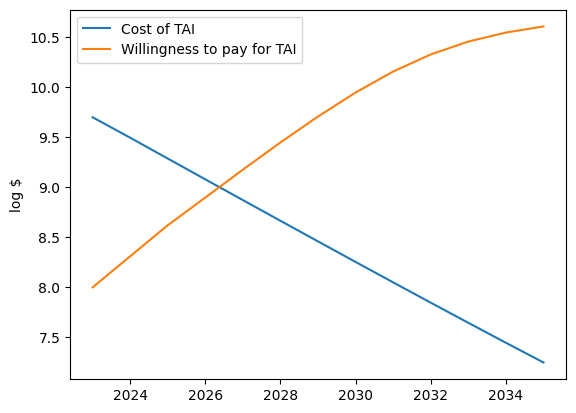

-
-
## SAMPLE RUN 31 ##
It takes 34.8 log FLOP (~63 decillion) for transformative capabilities.
Every 1.5 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 3.0 years they get 2x cheaper, to a maximum of 22.2 log FLOP (~16 sextillion) per 2022$USD.
We are initially willing to pay 8.6 log 2022$USD (~398 million). This doubles every 0.9 years until 2025, and then doubles every 2.6 years to a max of 0.000114% of GDP. GDP grows at a rate of 1.012x per year.
---
Year: 2023 - 26.8 max log FLOP (690 septillion) available - TAI takes 34.8 log FLOP (63 decillion) - log $ 16.5 to buy TAI (32 quadrillion) vs. willingness to pay log $ 8.5 (346 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 27.2 max log FLOP (2 octillion) available - TAI takes 34.6 log FLOP (40 decillion) - log $ 16.2 to buy TAI (16 quadrillion) vs. willingness to pay log $ 8.8 (638 million) - 18.4 log FLOP per $ (3 quintillion)
Yea

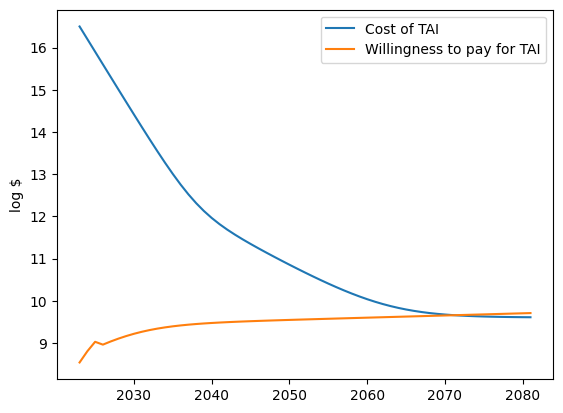

-
-
## SAMPLE RUN 32 ##
It takes 46.1 log FLOP (~13 trillion decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 5 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.3 years they get 2x cheaper, to a maximum of 21.7 log FLOP (~5 sextillion) per 2022$USD.
We are initially willing to pay 8.1 log 2022$USD (~126 million). This doubles every 1.0 years until 2025, and then doubles every 4.4 years to a max of 0.00038% of GDP. GDP grows at a rate of 1.027x per year.
---
Year: 2023 - 26.4 max log FLOP (248 septillion) available - TAI takes 46.1 log FLOP (13 trillion decillion) - log $ 27.8 to buy TAI (6 octillion) vs. willingness to pay log $ 8.1 (124 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.8 max log FLOP (674 septillion) available - TAI takes 45.8 log FLOP (6 trillion decillion) - log $ 27.4 to buy TAI (2 octillion) vs. willingness to pay log $ 8.4 (250 million) - 18.4 log FLOP per $ 

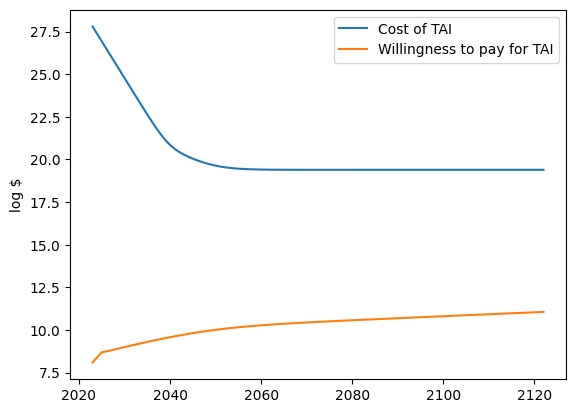

-
-
## SAMPLE RUN 33 ##
It takes 29.9 log FLOP (~794 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.4 years they get 2x cheaper, to a maximum of 22.2 log FLOP (~15 sextillion) per 2022$USD.
We are initially willing to pay 8.9 log 2022$USD (~794 million). This doubles every 1.0 years until 2025, and then doubles every 2.8 years to a max of 0.000109% of GDP. GDP grows at a rate of 1.032x per year.
---
Year: 2023 - 27.1 max log FLOP (1 octillion) available - TAI takes 29.9 log FLOP (794 octillion) - log $ 11.6 to buy TAI (398 billion) vs. willingness to pay log $ 8.8 (603 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 27.4 max log FLOP (3 octillion) available - TAI takes 29.8 log FLOP (638 octillion) - log $ 11.4 to buy TAI (239 billion) vs. willingness to pay log $ 9.0 (999 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 202

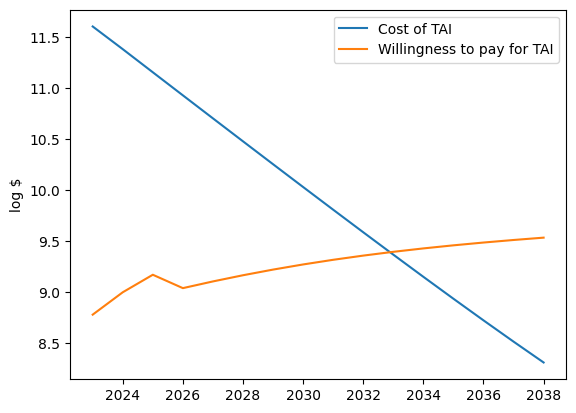

-
-
## SAMPLE RUN 34 ##
It takes 30.3 log FLOP (~2 nonillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.6 years they get 2x cheaper, to a maximum of 21.1 log FLOP (~1 sextillion) per 2022$USD.
We are initially willing to pay 8.7 log 2022$USD (~501 million). This doubles every 1.0 years until 2025, and then doubles every 1 years to a max of 0.000499% of GDP. GDP grows at a rate of 1.024x per year.
---
Year: 2023 - 27.0 max log FLOP (957 septillion) available - TAI takes 30.3 log FLOP (2 nonillion) - log $ 12.0 to buy TAI (1 trillion) vs. willingness to pay log $ 8.7 (480 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 27.4 max log FLOP (2 octillion) available - TAI takes 30.2 log FLOP (2 nonillion) - log $ 11.8 to buy TAI (588 billion) vs. willingness to pay log $ 9.0 (939 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 27.

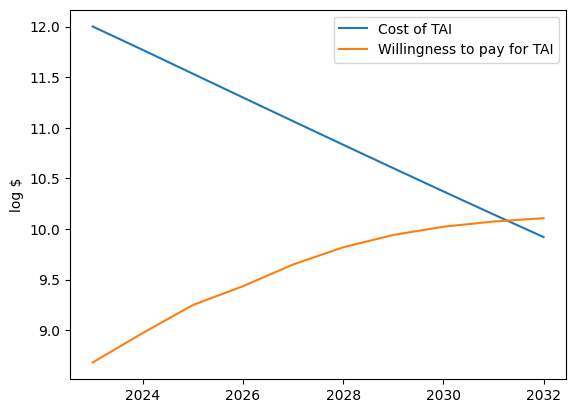

-
-
## SAMPLE RUN 35 ##
It takes 38.3 log FLOP (~200 thousand decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 4 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.0 years they get 2x cheaper, to a maximum of 22.1 log FLOP (~13 sextillion) per 2022$USD.
We are initially willing to pay 8.2 log 2022$USD (~158 million). This doubles every 1.0 years until 2025, and then doubles every 3.7 years to a max of 0.000225% of GDP. GDP grows at a rate of 1.025x per year.
---
Year: 2023 - 26.5 max log FLOP (307 septillion) available - TAI takes 38.3 log FLOP (200 thousand decillion) - log $ 20.0 to buy TAI (100 quintillion) vs. willingness to pay log $ 8.2 (154 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.9 max log FLOP (872 septillion) available - TAI takes 38.0 log FLOP (100 thousand decillion) - log $ 19.5 to buy TAI (35 quintillion) vs. willingness to pay log $ 8.5 (308 million) - 18.5 lo

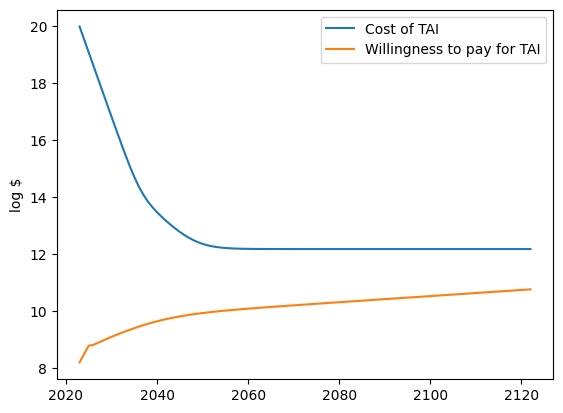

-
-
## SAMPLE RUN 36 ##
It takes 30.7 log FLOP (~5 nonillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.0 years they get 2x cheaper, to a maximum of 21.0 log FLOP (~1 sextillion) per 2022$USD.
We are initially willing to pay 8.3 log 2022$USD (~200 million). This doubles every 1.0 years until 2025, and then doubles every 4.8 years to a max of 0.00066% of GDP. GDP grows at a rate of 1.014x per year.
---
Year: 2023 - 26.6 max log FLOP (392 septillion) available - TAI takes 30.7 log FLOP (5 nonillion) - log $ 12.4 to buy TAI (3 trillion) vs. willingness to pay log $ 8.3 (197 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 27.0 max log FLOP (1 octillion) available - TAI takes 30.6 log FLOP (4 nonillion) - log $ 12.1 to buy TAI (1 trillion) vs. willingness to pay log $ 8.6 (399 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 27.

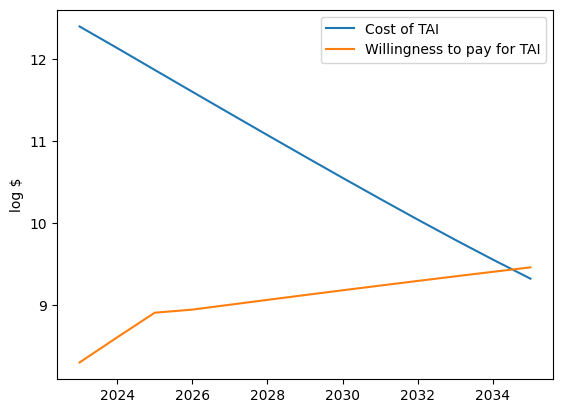

-
-
## SAMPLE RUN 37 ##
It takes 29.6 log FLOP (~398 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.9 years they get 2x cheaper, to a maximum of 21.2 log FLOP (~1 sextillion) per 2022$USD.
We are initially willing to pay 8.8 log 2022$USD (~631 million). This doubles every 1.0 years until 2025, and then doubles every 3.4 years to a max of 0.000434% of GDP. GDP grows at a rate of 1.018x per year.
---
Year: 2023 - 27.1 max log FLOP (1 octillion) available - TAI takes 29.6 log FLOP (398 octillion) - log $ 11.3 to buy TAI (200 billion) vs. willingness to pay log $ 8.8 (593 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 27.5 max log FLOP (3 octillion) available - TAI takes 29.5 log FLOP (320 octillion) - log $ 11.1 to buy TAI (126 billion) vs. willingness to pay log $ 9.0 (1 billion) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 -

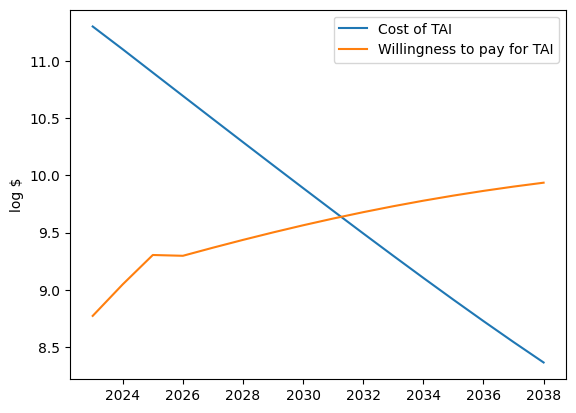

-
-
## SAMPLE RUN 38 ##
It takes 33.7 log FLOP (~5 decillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.0 years they get 2x cheaper, to a maximum of 23.0 log FLOP (~96 sextillion) per 2022$USD.
We are initially willing to pay 8.3 log 2022$USD (~200 million). This doubles every 0.9 years until 2025, and then doubles every 1 years to a max of 0.000313% of GDP. GDP grows at a rate of 1.031x per year.
---
Year: 2023 - 26.6 max log FLOP (387 septillion) available - TAI takes 33.7 log FLOP (5 decillion) - log $ 15.4 to buy TAI (3 quadrillion) vs. willingness to pay log $ 8.3 (194 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 27.0 max log FLOP (1 octillion) available - TAI takes 33.6 log FLOP (4 decillion) - log $ 15.1 to buy TAI (1 quadrillion) vs. willingness to pay log $ 8.6 (392 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025

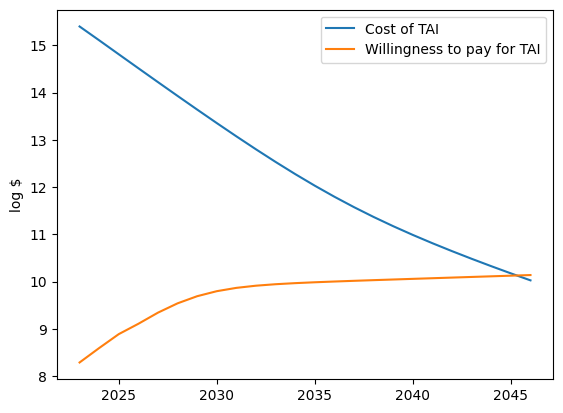

-
-
## SAMPLE RUN 39 ##
It takes 27.2 log FLOP (~2 octillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.6 years they get 2x cheaper, to a maximum of 21.8 log FLOP (~6 sextillion) per 2022$USD.
We are initially willing to pay 8.7 log 2022$USD (~501 million). This doubles every 1.0 years until 2025, and then doubles every 6.1 years to a max of 0.000458% of GDP. GDP grows at a rate of 1.005x per year.
---
Year: 2023 - 27.0 max log FLOP (954 septillion) available - TAI takes 27.2 log FLOP (2 octillion) - log $ 8.9 to buy TAI (795 million) vs. willingness to pay log $ 8.7 (478 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 27.4 max log FLOP (2 octillion) available - TAI takes 27.1 log FLOP (1 octillion) - log $ 8.7 to buy TAI (487 million) vs. willingness to pay log $ 9.0 (927 million) - 18.4 log FLOP per $ (3 quintillion)
-- algorithms p_n

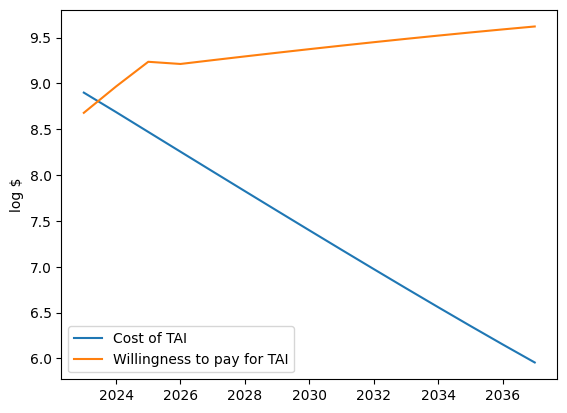

-
-
## SAMPLE RUN 40 ##
It takes 28.2 log FLOP (~16 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.9 years they get 2x cheaper, to a maximum of 23.0 log FLOP (~95 sextillion) per 2022$USD.
We are initially willing to pay 7.9 log 2022$USD (~79 million). This doubles every 1.0 years until 2025, and then doubles every 4.0 years to a max of 0.000418% of GDP. GDP grows at a rate of 1.026x per year.
---
Year: 2023 - 26.2 max log FLOP (157 septillion) available - TAI takes 28.2 log FLOP (16 octillion) - log $ 9.9 to buy TAI (8 billion) vs. willingness to pay log $ 7.9 (79 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.6 max log FLOP (411 septillion) available - TAI takes 28.1 log FLOP (13 octillion) - log $ 9.7 to buy TAI (5 billion) vs. willingness to pay log $ 8.2 (162 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 2

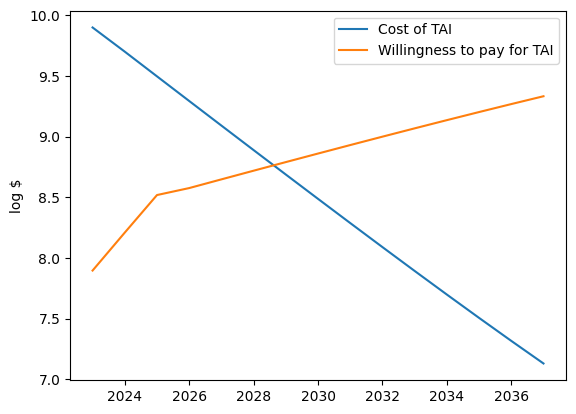

-
-
## SAMPLE RUN 41 ##
It takes 27.8 log FLOP (~6 octillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.3 years they get 2x cheaper, to a maximum of 22.7 log FLOP (~47 sextillion) per 2022$USD.
We are initially willing to pay 8.1 log 2022$USD (~126 million). This doubles every 0.9 years until 2025, and then doubles every 4.5 years to a max of 0.000178% of GDP. GDP grows at a rate of 1.024x per year.
---
Year: 2023 - 26.4 max log FLOP (244 septillion) available - TAI takes 27.8 log FLOP (6 octillion) - log $ 9.5 to buy TAI (3 billion) vs. willingness to pay log $ 8.1 (122 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.8 max log FLOP (668 septillion) available - TAI takes 27.7 log FLOP (5 octillion) - log $ 9.3 to buy TAI (2 billion) vs. willingness to pay log $ 8.4 (249 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 27.3

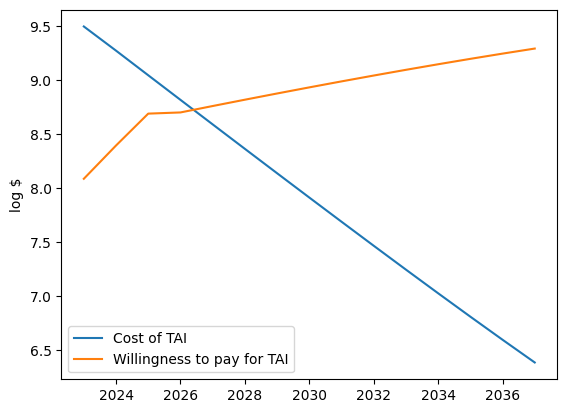

-
-
## SAMPLE RUN 42 ##
It takes 29.7 log FLOP (~501 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.4 years they get 2x cheaper, to a maximum of 21.0 log FLOP (~938 quintillion) per 2022$USD.
We are initially willing to pay 8.5 log 2022$USD (~316 million). This doubles every 1.0 years until 2025, and then doubles every 3.1 years to a max of 6e-06% of GDP. GDP grows at a rate of 1.021x per year.
---
Year: 2023 - 26.3 max log FLOP (201 septillion) available - TAI takes 29.7 log FLOP (501 octillion) - log $ 11.4 to buy TAI (252 billion) vs. willingness to pay log $ 8.0 (101 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.5 max log FLOP (325 septillion) available - TAI takes 29.6 log FLOP (403 octillion) - log $ 11.2 to buy TAI (152 billion) vs. willingness to pay log $ 8.1 (122 million) - 18.4 log FLOP per $ (3 quintillion)
Year

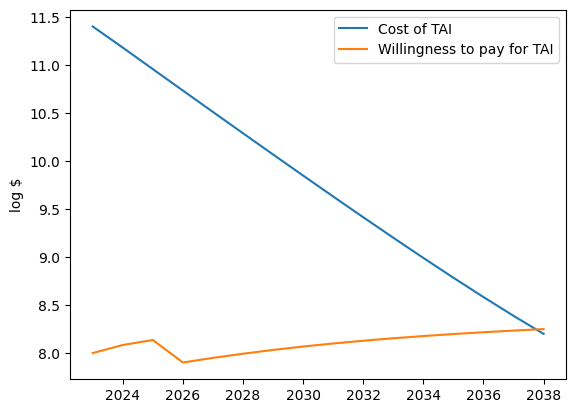

-
-
## SAMPLE RUN 43 ##
It takes 36.1 log FLOP (~1 thousand decillion) for transformative capabilities.
Every 1.0 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.5 years they get 2x cheaper, to a maximum of 23.4 log FLOP (~275 sextillion) per 2022$USD.
We are initially willing to pay 8.5 log 2022$USD (~316 million). This doubles every 1.0 years until 2025, and then doubles every 3.2 years to a max of 0.000627% of GDP. GDP grows at a rate of 1.031x per year.
---
Year: 2023 - 26.8 max log FLOP (617 septillion) available - TAI takes 36.1 log FLOP (1 thousand decillion) - log $ 17.8 to buy TAI (631 quadrillion) vs. willingness to pay log $ 8.5 (309 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 27.2 max log FLOP (2 octillion) available - TAI takes 35.8 log FLOP (631 decillion) - log $ 17.4 to buy TAI (239 quadrillion) vs. willingness to pay log $ 8.8 (617 million) - 18.4 log FLOP per $

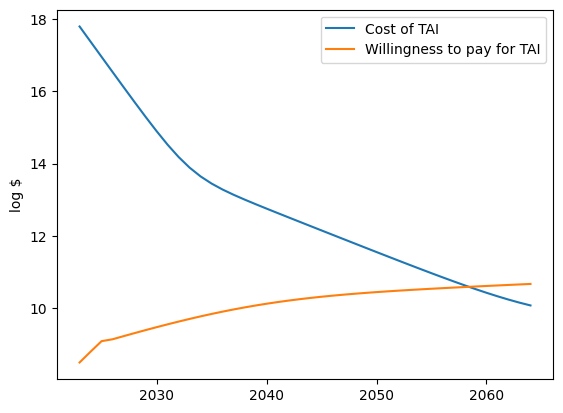

-
-
## SAMPLE RUN 44 ##
It takes 33.7 log FLOP (~5 decillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.5 years they get 2x cheaper, to a maximum of 23.7 log FLOP (~486 sextillion) per 2022$USD.
We are initially willing to pay 8.0 log 2022$USD (~100 million). This doubles every 1.0 years until 2025, and then doubles every 2.4 years to a max of 0.000415% of GDP. GDP grows at a rate of 1.028x per year.
---
Year: 2023 - 26.3 max log FLOP (197 septillion) available - TAI takes 33.7 log FLOP (5 decillion) - log $ 15.4 to buy TAI (3 quadrillion) vs. willingness to pay log $ 8.0 (99 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.7 max log FLOP (525 septillion) available - TAI takes 33.6 log FLOP (4 decillion) - log $ 15.1 to buy TAI (1 quadrillion) vs. willingness to pay log $ 8.3 (199 million) - 18.4 log FLOP per $ (3 quintillion)
Year:

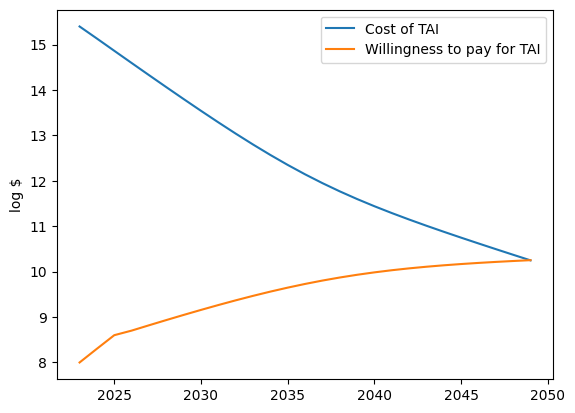

-
-
## SAMPLE RUN 45 ##
It takes 28.5 log FLOP (~32 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.6 years they get 2x cheaper, to a maximum of 21.0 log FLOP (~942 quintillion) per 2022$USD.
We are initially willing to pay 8.6 log 2022$USD (~398 million). This doubles every 1.0 years until 2025, and then doubles every 1.5 years to a max of 0.004045% of GDP. GDP grows at a rate of 1.023x per year.
---
Year: 2023 - 26.9 max log FLOP (789 septillion) available - TAI takes 28.5 log FLOP (32 octillion) - log $ 10.2 to buy TAI (16 billion) vs. willingness to pay log $ 8.6 (396 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 27.3 max log FLOP (2 octillion) available - TAI takes 28.4 log FLOP (25 octillion) - log $ 10.0 to buy TAI (10 billion) vs. willingness to pay log $ 8.9 (775 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 202

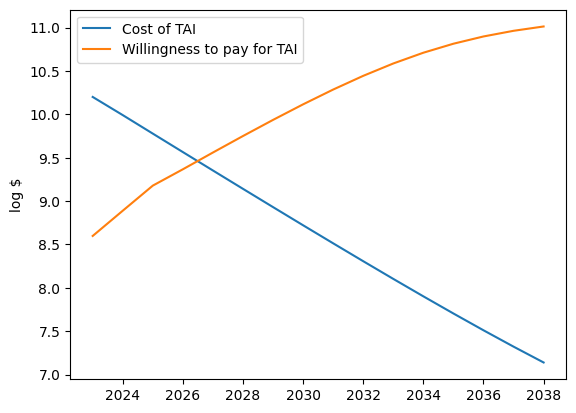

-
-
## SAMPLE RUN 46 ##
It takes 35.8 log FLOP (~631 decillion) for transformative capabilities.
Every 1.5 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.7 years they get 2x cheaper, to a maximum of 22.0 log FLOP (~9 sextillion) per 2022$USD.
We are initially willing to pay 9.5 log 2022$USD (~3 billion). This doubles every 1.0 years until 2025, and then doubles every 3.6 years to a max of 0.00021% of GDP. GDP grows at a rate of 1.013x per year.
---
Year: 2023 - 27.6 max log FLOP (4 octillion) available - TAI takes 35.8 log FLOP (631 decillion) - log $ 17.5 to buy TAI (316 quadrillion) vs. willingness to pay log $ 9.3 (2 billion) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 27.9 max log FLOP (7 octillion) available - TAI takes 35.6 log FLOP (398 decillion) - log $ 17.2 to buy TAI (154 quadrillion) vs. willingness to pay log $ 9.4 (3 billion) - 18.4 log FLOP per $ (3 quintillion)
Year: 202

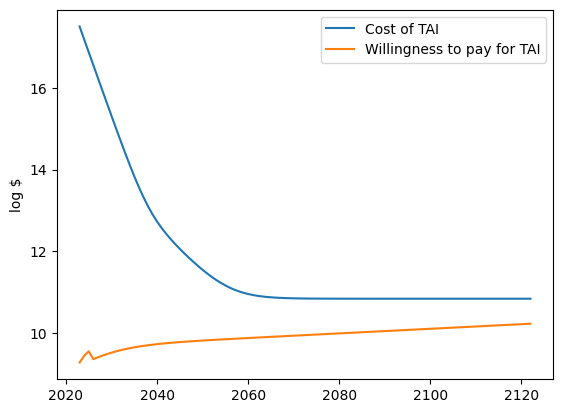

-
-
## SAMPLE RUN 47 ##
It takes 33.6 log FLOP (~4 decillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.4 years they get 2x cheaper, to a maximum of 20.4 log FLOP (~257 quintillion) per 2022$USD.
We are initially willing to pay 9.0 log 2022$USD (~1 billion). This doubles every 1.0 years until 2025, and then doubles every 3.7 years to a max of 8e-06% of GDP. GDP grows at a rate of 1.023x per year.
---
Year: 2023 - 26.5 max log FLOP (301 septillion) available - TAI takes 33.6 log FLOP (4 decillion) - log $ 15.3 to buy TAI (2 quadrillion) vs. willingness to pay log $ 8.2 (152 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.6 max log FLOP (442 septillion) available - TAI takes 33.5 log FLOP (3 decillion) - log $ 15.0 to buy TAI (1 quadrillion) vs. willingness to pay log $ 8.2 (168 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 20

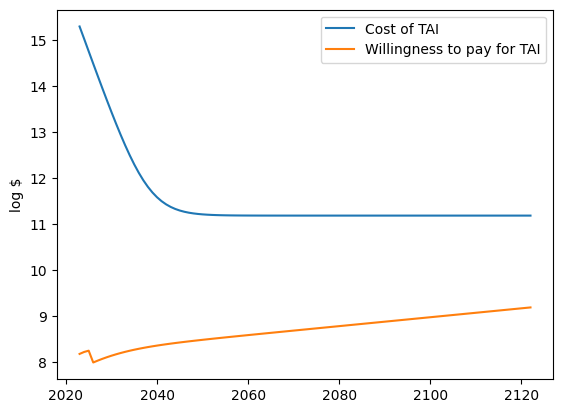

-
-
## SAMPLE RUN 48 ##
It takes 27.1 log FLOP (~1 octillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.6 years they get 2x cheaper, to a maximum of 22.4 log FLOP (~24 sextillion) per 2022$USD.
We are initially willing to pay 8.1 log 2022$USD (~126 million). This doubles every 1.0 years until 2025, and then doubles every 3.3 years to a max of 0.000727% of GDP. GDP grows at a rate of 1.017x per year.
---
Year: 2023 - 26.4 max log FLOP (249 septillion) available - TAI takes 27.1 log FLOP (1 octillion) - log $ 8.8 to buy TAI (631 million) vs. willingness to pay log $ 8.1 (125 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.8 max log FLOP (646 septillion) available - TAI takes 27.0 log FLOP (1 octillion) - log $ 8.6 to buy TAI (388 million) vs. willingness to pay log $ 8.4 (248 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 

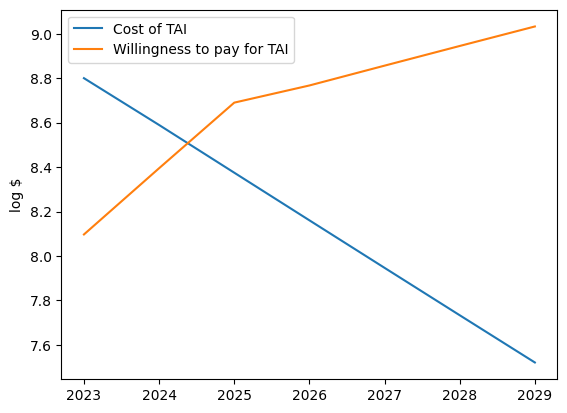

-
-
## SAMPLE RUN 49 ##
It takes 30.5 log FLOP (~3 nonillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.4 years they get 2x cheaper, to a maximum of 22.7 log FLOP (~54 sextillion) per 2022$USD.
We are initially willing to pay 8.2 log 2022$USD (~158 million). This doubles every 0.9 years until 2025, and then doubles every 4.5 years to a max of 0.000199% of GDP. GDP grows at a rate of 1.012x per year.
---
Year: 2023 - 26.5 max log FLOP (306 septillion) available - TAI takes 30.5 log FLOP (3 nonillion) - log $ 12.2 to buy TAI (2 trillion) vs. willingness to pay log $ 8.2 (153 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.9 max log FLOP (827 septillion) available - TAI takes 30.4 log FLOP (2 nonillion) - log $ 12.0 to buy TAI (910 billion) vs. willingness to pay log $ 8.5 (310 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025

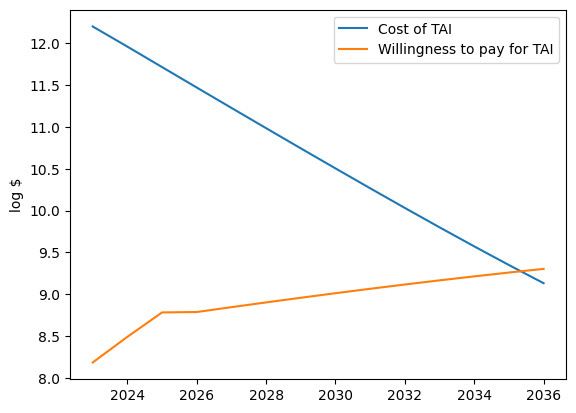

-
-
## SAMPLE RUN 50 ##
It takes 33.8 log FLOP (~6 decillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.5 years they get 2x cheaper, to a maximum of 23.8 log FLOP (~574 sextillion) per 2022$USD.
We are initially willing to pay 8.2 log 2022$USD (~158 million). This doubles every 1.0 years until 2025, and then doubles every 3.5 years to a max of 0.000872% of GDP. GDP grows at a rate of 1.013x per year.
---
Year: 2023 - 26.5 max log FLOP (314 septillion) available - TAI takes 33.8 log FLOP (6 decillion) - log $ 15.5 to buy TAI (3 quadrillion) vs. willingness to pay log $ 8.2 (157 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.9 max log FLOP (831 septillion) available - TAI takes 33.7 log FLOP (5 decillion) - log $ 15.2 to buy TAI (2 quadrillion) vs. willingness to pay log $ 8.5 (317 million) - 18.4 log FLOP per $ (3 quintillion)
Year

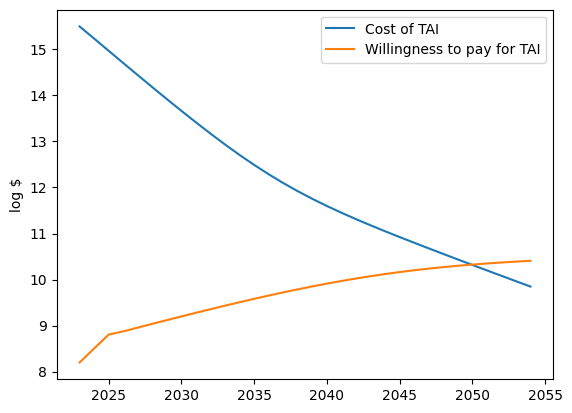

-
-
## SAMPLE RUN 51 ##
It takes 47.0 log FLOP (~100 trillion decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 5 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.6 years they get 2x cheaper, to a maximum of 22.0 log FLOP (~9 sextillion) per 2022$USD.
We are initially willing to pay 8.7 log 2022$USD (~501 million). This doubles every 1.0 years until 2025, and then doubles every 1.7 years to a max of 0.001773% of GDP. GDP grows at a rate of 1.032x per year.
---
Year: 2023 - 27.0 max log FLOP (988 septillion) available - TAI takes 47.0 log FLOP (100 trillion decillion) - log $ 28.7 to buy TAI (50 octillion) vs. willingness to pay log $ 8.7 (495 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 27.4 max log FLOP (3 octillion) available - TAI takes 46.7 log FLOP (50 trillion decillion) - log $ 28.3 to buy TAI (19 octillion) vs. willingness to pay log $ 9.0 (974 million) - 18.4 log FLOP per

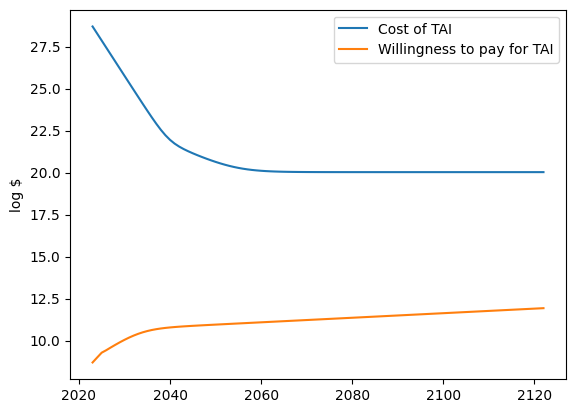

-
-
## SAMPLE RUN 52 ##
It takes 27.3 log FLOP (~2 octillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.9 years they get 2x cheaper, to a maximum of 22.5 log FLOP (~32 sextillion) per 2022$USD.
We are initially willing to pay 8.0 log 2022$USD (~100 million). This doubles every 0.9 years until 2025, and then doubles every 2.4 years to a max of 0.000161% of GDP. GDP grows at a rate of 1.029x per year.
---
Year: 2023 - 26.3 max log FLOP (194 septillion) available - TAI takes 27.3 log FLOP (2 octillion) - log $ 9.0 to buy TAI (1 billion) vs. willingness to pay log $ 8.0 (97 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.7 max log FLOP (505 septillion) available - TAI takes 27.2 log FLOP (2 octillion) - log $ 8.8 to buy TAI (632 million) vs. willingness to pay log $ 8.3 (199 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 27.

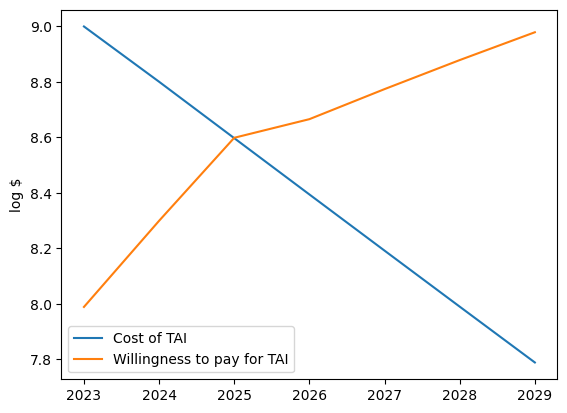

-
-
## SAMPLE RUN 53 ##
It takes 29.3 log FLOP (~200 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.5 years they get 2x cheaper, to a maximum of 22.9 log FLOP (~85 sextillion) per 2022$USD.
We are initially willing to pay 8.6 log 2022$USD (~398 million). This doubles every 1.0 years until 2025, and then doubles every 3.7 years to a max of 0.000364% of GDP. GDP grows at a rate of 1.039x per year.
---
Year: 2023 - 26.9 max log FLOP (758 septillion) available - TAI takes 29.3 log FLOP (200 octillion) - log $ 11.0 to buy TAI (100 billion) vs. willingness to pay log $ 8.6 (380 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 27.3 max log FLOP (2 octillion) available - TAI takes 29.2 log FLOP (160 octillion) - log $ 10.8 to buy TAI (61 billion) vs. willingness to pay log $ 8.9 (744 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2

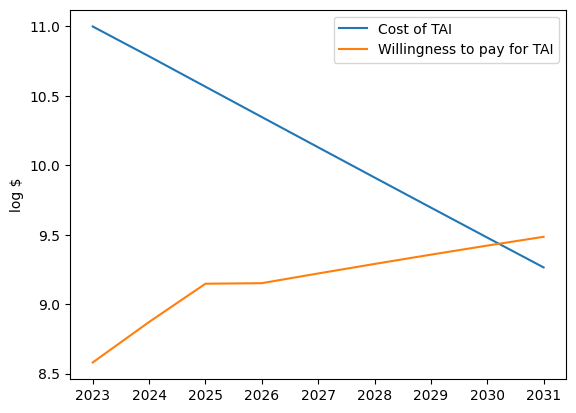

In [8]:
for i in range(50):
    print('-')
    print('-')
    print('## SAMPLE RUN {} ##'.format(i + 3 + 1))
    define_tai_timeline_event(verbose=True)